Using this pipeline https://smorabit.github.io/tutorials/8_velocyto/
Use different clustering numbers

In [ ]:
#mount drive
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# update to the latest version, if not done yet.
!pip install scvelo --upgrade --quiet
!pip install python-igraph
!pip install pybind11 hnswlib

In [ ]:

#First, import required packages in the current session.

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
import igraph
import scvelo as scv
import loompy as lmp
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import matplotlib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#!pip freeze on 20230726

absl-py==1.4.0
aiohttp==3.8.5
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
anndata==0.9.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
array-record==0.4.0
arviz==0.15.1
astropy==5.2.2
astunparse==1.6.3
async-timeout==4.0.2
attrs==23.1.0
audioread==3.0.0
autograd==1.6.2
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blinker==1.4
blis==0.7.10
blosc2==2.0.0
bokeh==3.1.1
branca==0.6.0
build==0.10.0
CacheControl==0.13.1
cachetools==5.3.1
catalogue==2.0.9
certifi==2023.7.22
cffi==1.15.1
chardet==4.0.0
charset-normalizer==2.0.12
chex==0.1.7
click==8.1.6
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.25.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.1.0
cons==0.4.6
contextlib2==21.6.0
contourpy==1.1.0
convertdate==2.4.0
cryptography==3.4.8
cufflinks==0.17.3
cvxopt==1.3.1
cvxpy==1.3.2
cycler==0.11.0
cymem==2.0.7
Cython==0.29.36
dask==2022.12.1
datascience==0.17.6
d

In [ ]:
# load sparse matrix:
X = io.mmread("/content/gdrive/MyDrive/singlecell_uribe/68h_Uribe_original_metadata/counts.mtx")

In [ ]:
# create anndata object
adata = anndata.AnnData(
    X=X.transpose().tocsr()
)

In [ ]:
# load cell metadata:
cell_meta = pd.read_csv("/content/gdrive/MyDrive/singlecell_uribe/68h_Uribe_original_metadata/metadata.csv")

In [ ]:
# load gene names:
with open("/content/gdrive/MyDrive/singlecell_uribe/68h_Uribe_original_metadata/gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines()

In [ ]:
# set anndata observations and index obs by barcodes, var by gene names
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

In [ ]:
# load dimensional reduction:
pca = pd.read_csv("/content/gdrive/MyDrive/singlecell_uribe/68h_Uribe_original_metadata/pca.csv")
pca.index = adata.obs.index

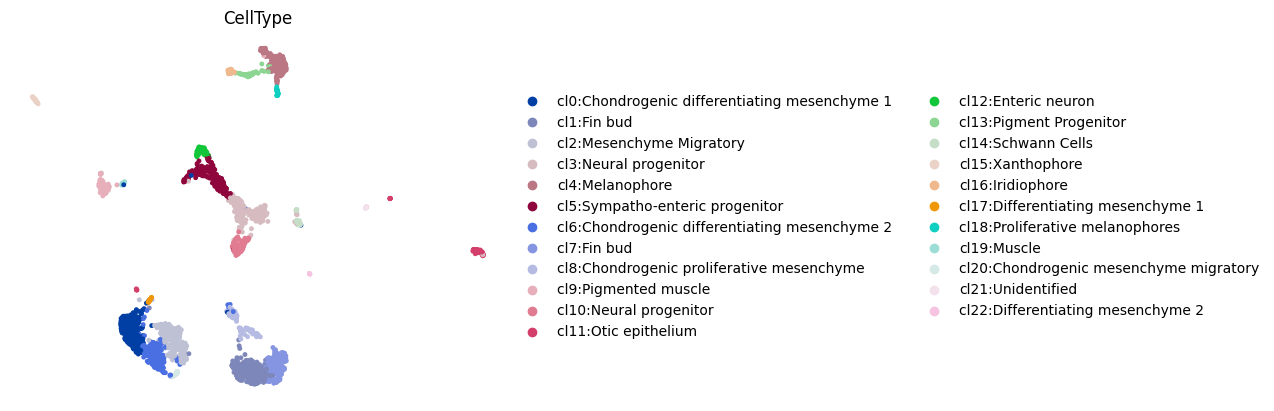

In [ ]:
# set pca and umap
adata.obsm['X_pca'] = pca.to_numpy()
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(), adata.obs['UMAP_2'].to_numpy())).T


sc.pl.umap(adata, frameon=False, color="CellType")

# save dataset as anndata format
adata.write('/content/gdrive/MyDrive/singlecell_uribe/68h_Uribe_original_metadata/seurat_original_data_68HPF_v20230726.h5ad')



In [ ]:
# reload dataset
adata = sc.read_h5ad('/content/gdrive/MyDrive/singlecell_uribe/68h_Uribe_original_metadata/seurat_original_data_68HPF_v20230726.h5ad')

In [ ]:
#shroter names to cluster
major_cell_type = ["CDM-1",
                      "fin bud-1",
                      "MM",
                      "NP-1" ,
                      "melanophore" ,
                      "SEP" ,
                      "CDM-2",
                      "fin bud-2",
                      "CPM" ,
                      "pigmented muscle" ,
                      "NP-2"   ,
                      "OE",
                      "EN" ,
                      "PP",
                      "SC" ,
                      "xanthophore",
                      "iridiophore",
                      "DM-1",
                      "PM",
                   "muscle",
                      "CMM",
                      "unindentified",
                      "DM-2"]
adata.rename_categories('CellType', major_cell_type)

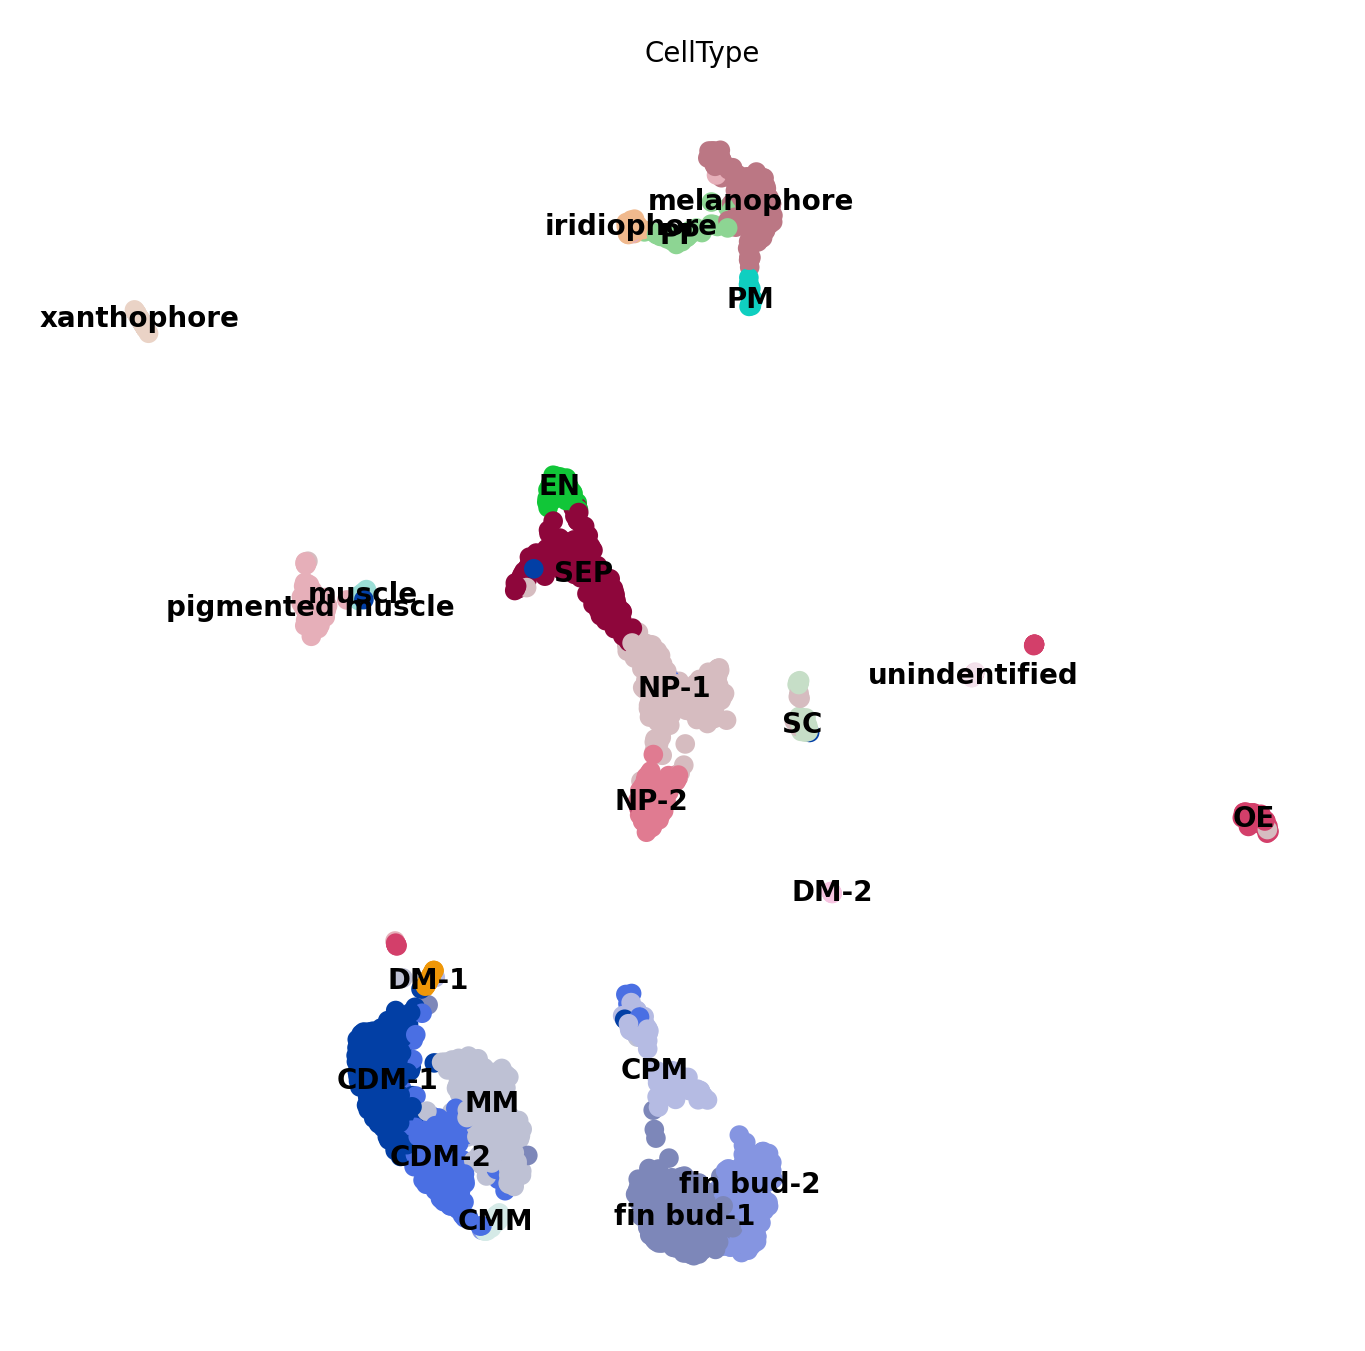

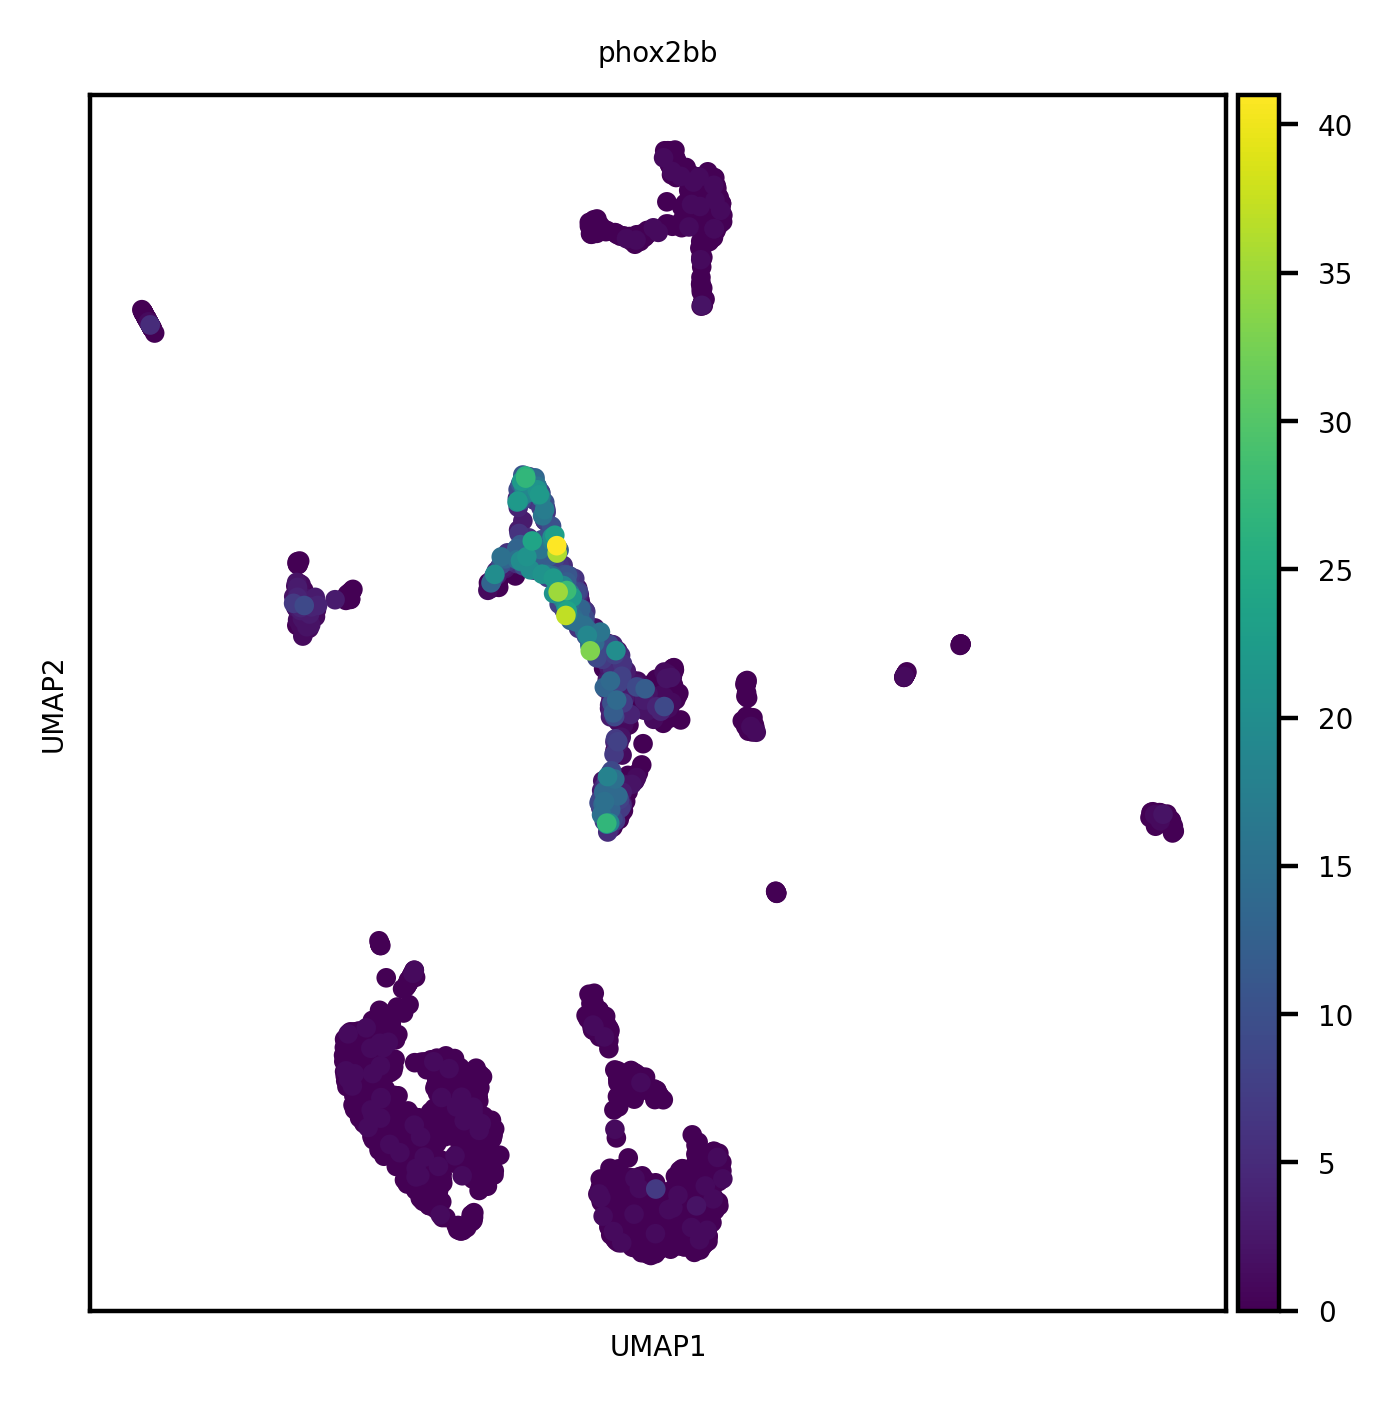

In [ ]:
sc.set_figure_params(scanpy=True, fontsize=5, dpi=200)
sc.pl.umap(adata, frameon=False, color="CellType", legend_loc="on data")

sc.pl.umap(adata, color=['phox2bb'])

In [ ]:
# here, make a dot plot with the main markers to reproduce the elife paper figure

In [ ]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.5 (python 3.10.6) on 2023-07-26 21:21.


In [ ]:
adata

AnnData object with n_obs × n_vars = 2410 × 17747
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1.2', 'seurat_clusters', 'CellType', 'barcode', 'UMAP_1', 'UMAP_2'
    uns: 'CellType_colors'
    obsm: 'X_pca', 'X_umap'

In [ ]:
# load loom files for spliced/unspliced matrices for each sample:
ldata1 = scv.read('/content/gdrive/MyDrive/singlecell_uribe/velocyto/outs_68h.loom')

In [ ]:
# rename barcodes in order to merge:
barcodes = [bc.split(':')[1] for bc in ldata1.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_10' for bc in barcodes]
ldata1.obs.index = barcodes

In [ ]:
# make variable names unique
ldata1.var_names_make_unique()

In [ ]:
# merge matrices into the original adata object

adata = scv.utils.merge(adata, ldata1, id_length=10)


In [ ]:
adata

AnnData object with n_obs × n_vars = 2410 × 14679
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1.2', 'seurat_clusters', 'CellType', 'barcode', 'UMAP_1', 'UMAP_2', 'sample_batch', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'CellType_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

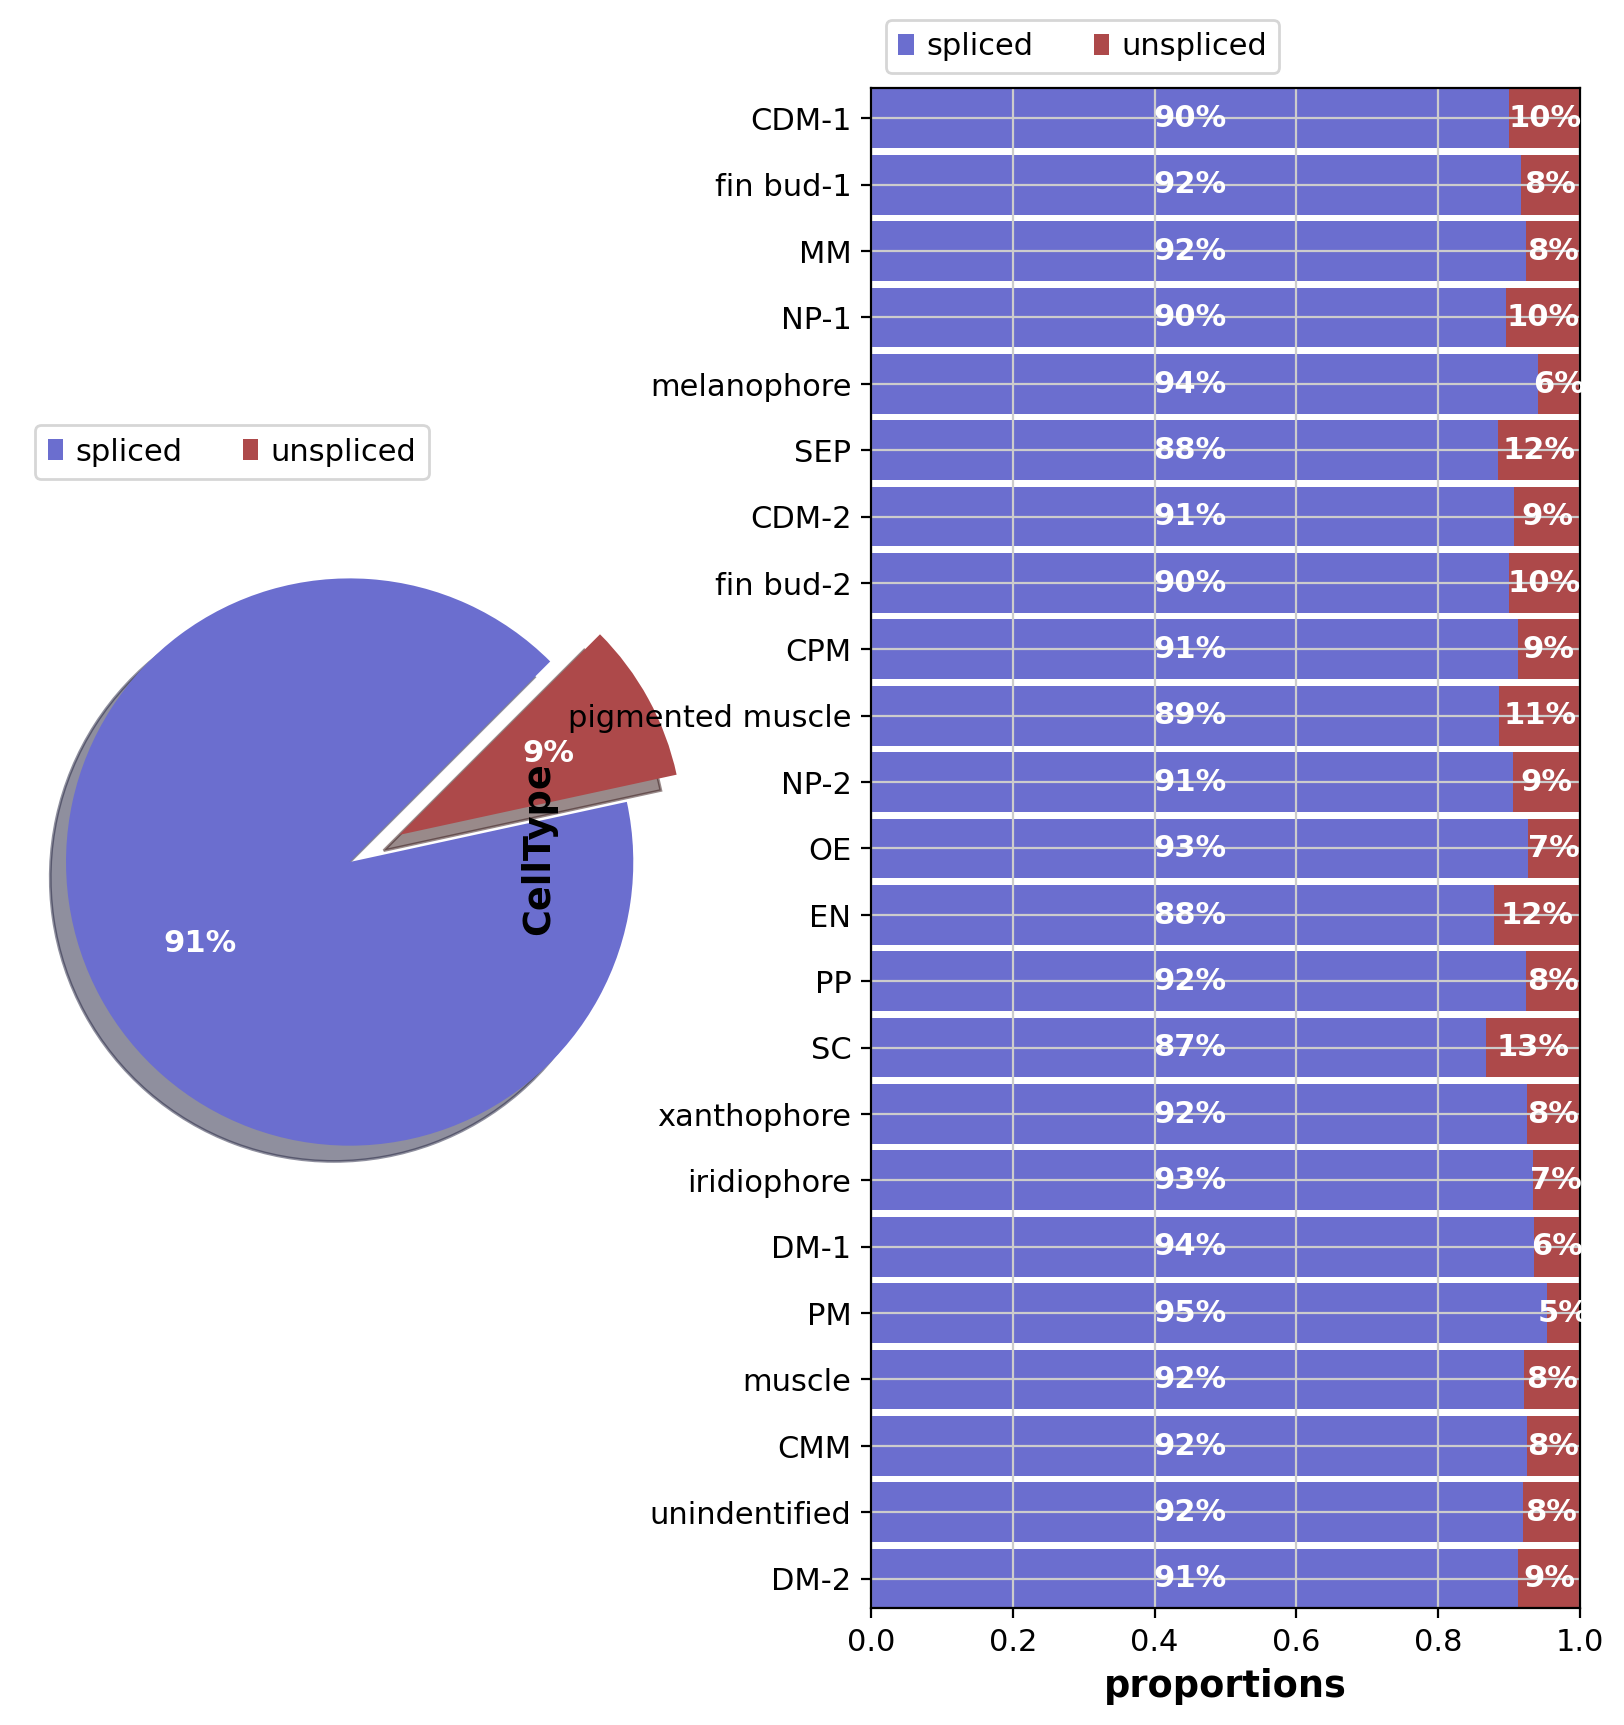

In [ ]:
scv.pl.proportions(adata, groupby='CellType', figsize=(10, 10), fontsize=11)

In [ ]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata, n_pcs=20, n_neighbors=50)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:37) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/2 cores)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/4351 [00:00<?, ?gene/s]

    finished (0:34:56) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [ ]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:21) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/2410 [00:00<?, ?cells/s]

    finished (0:00:56) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


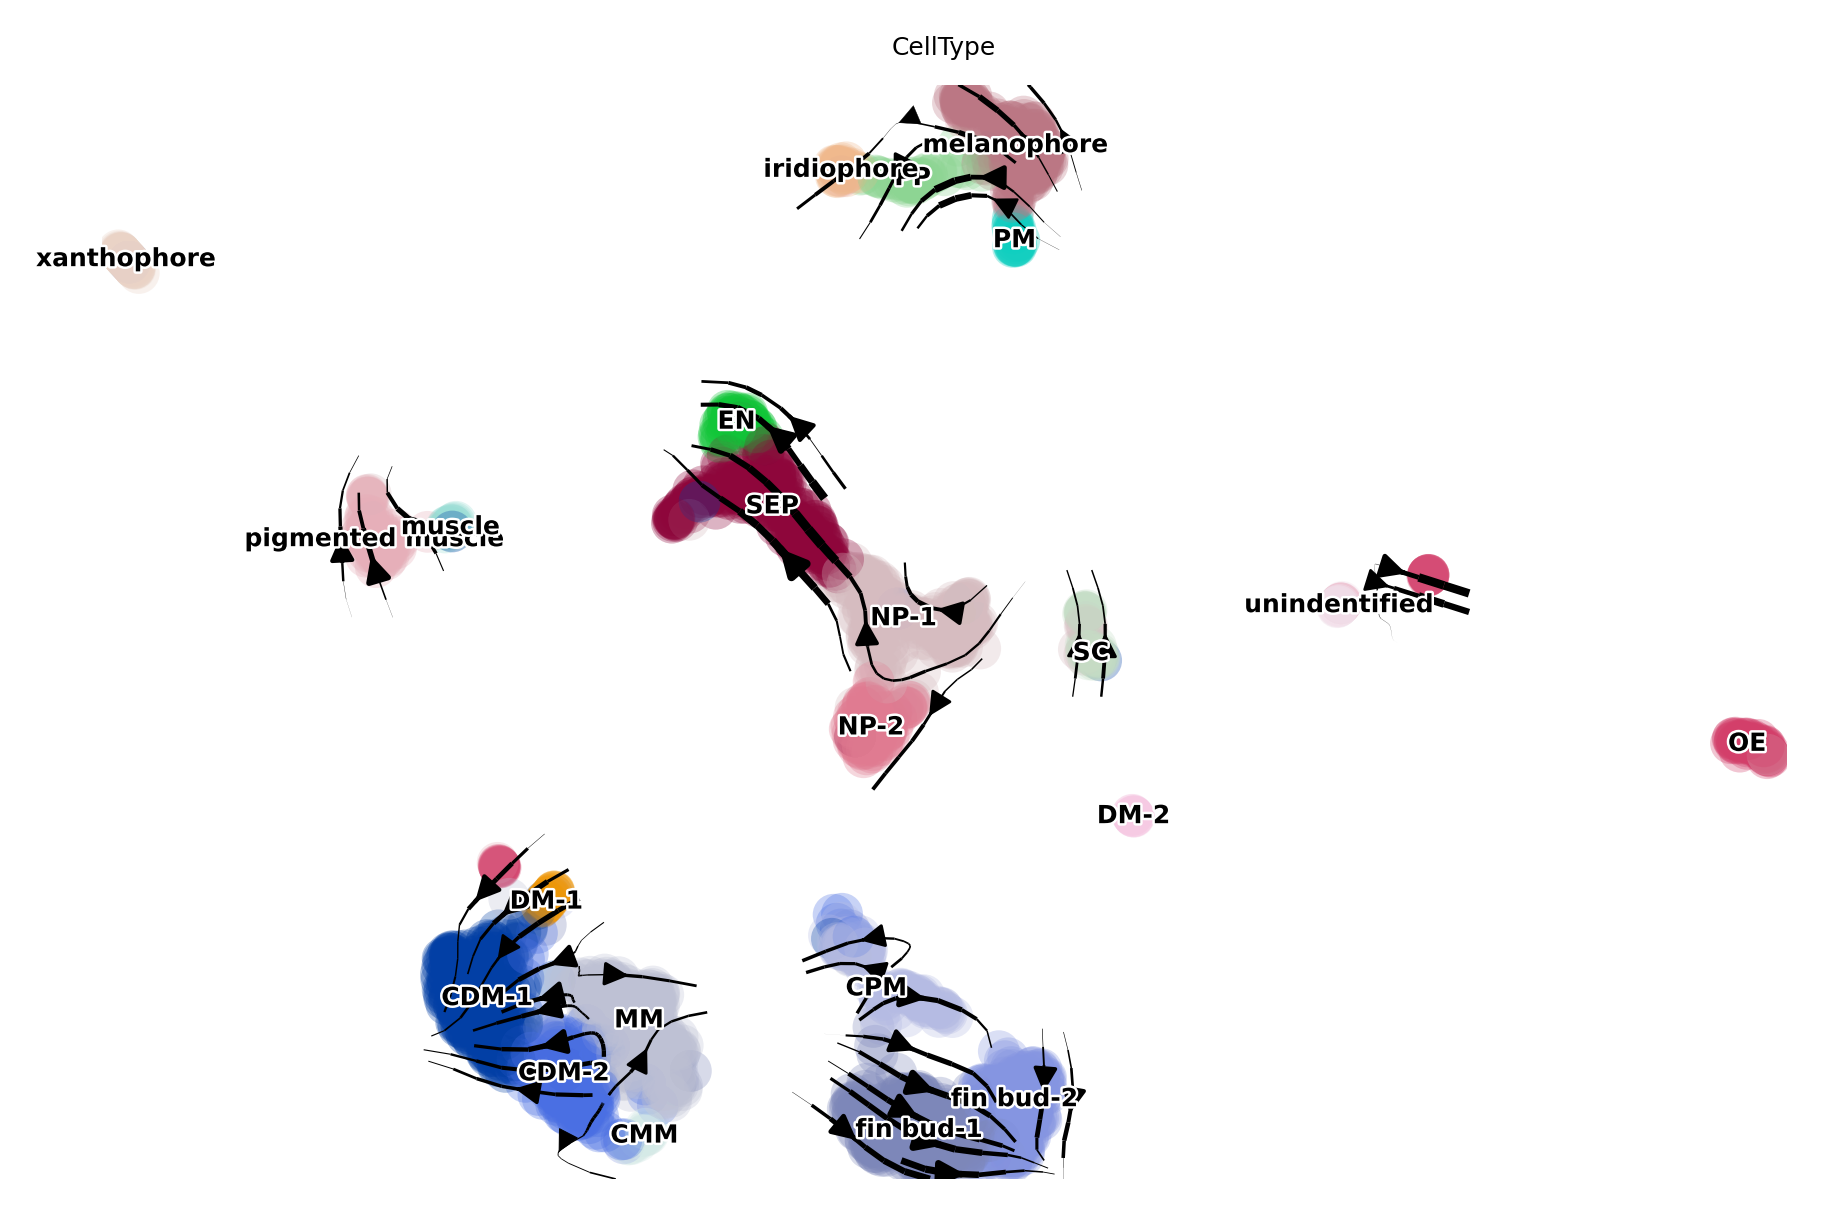

In [ ]:
scv.set_figure_params('scvelo', fontsize=5, dpi=180)
scv.pl.velocity_embedding_stream(adata, basis='umap', color='CellType')

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


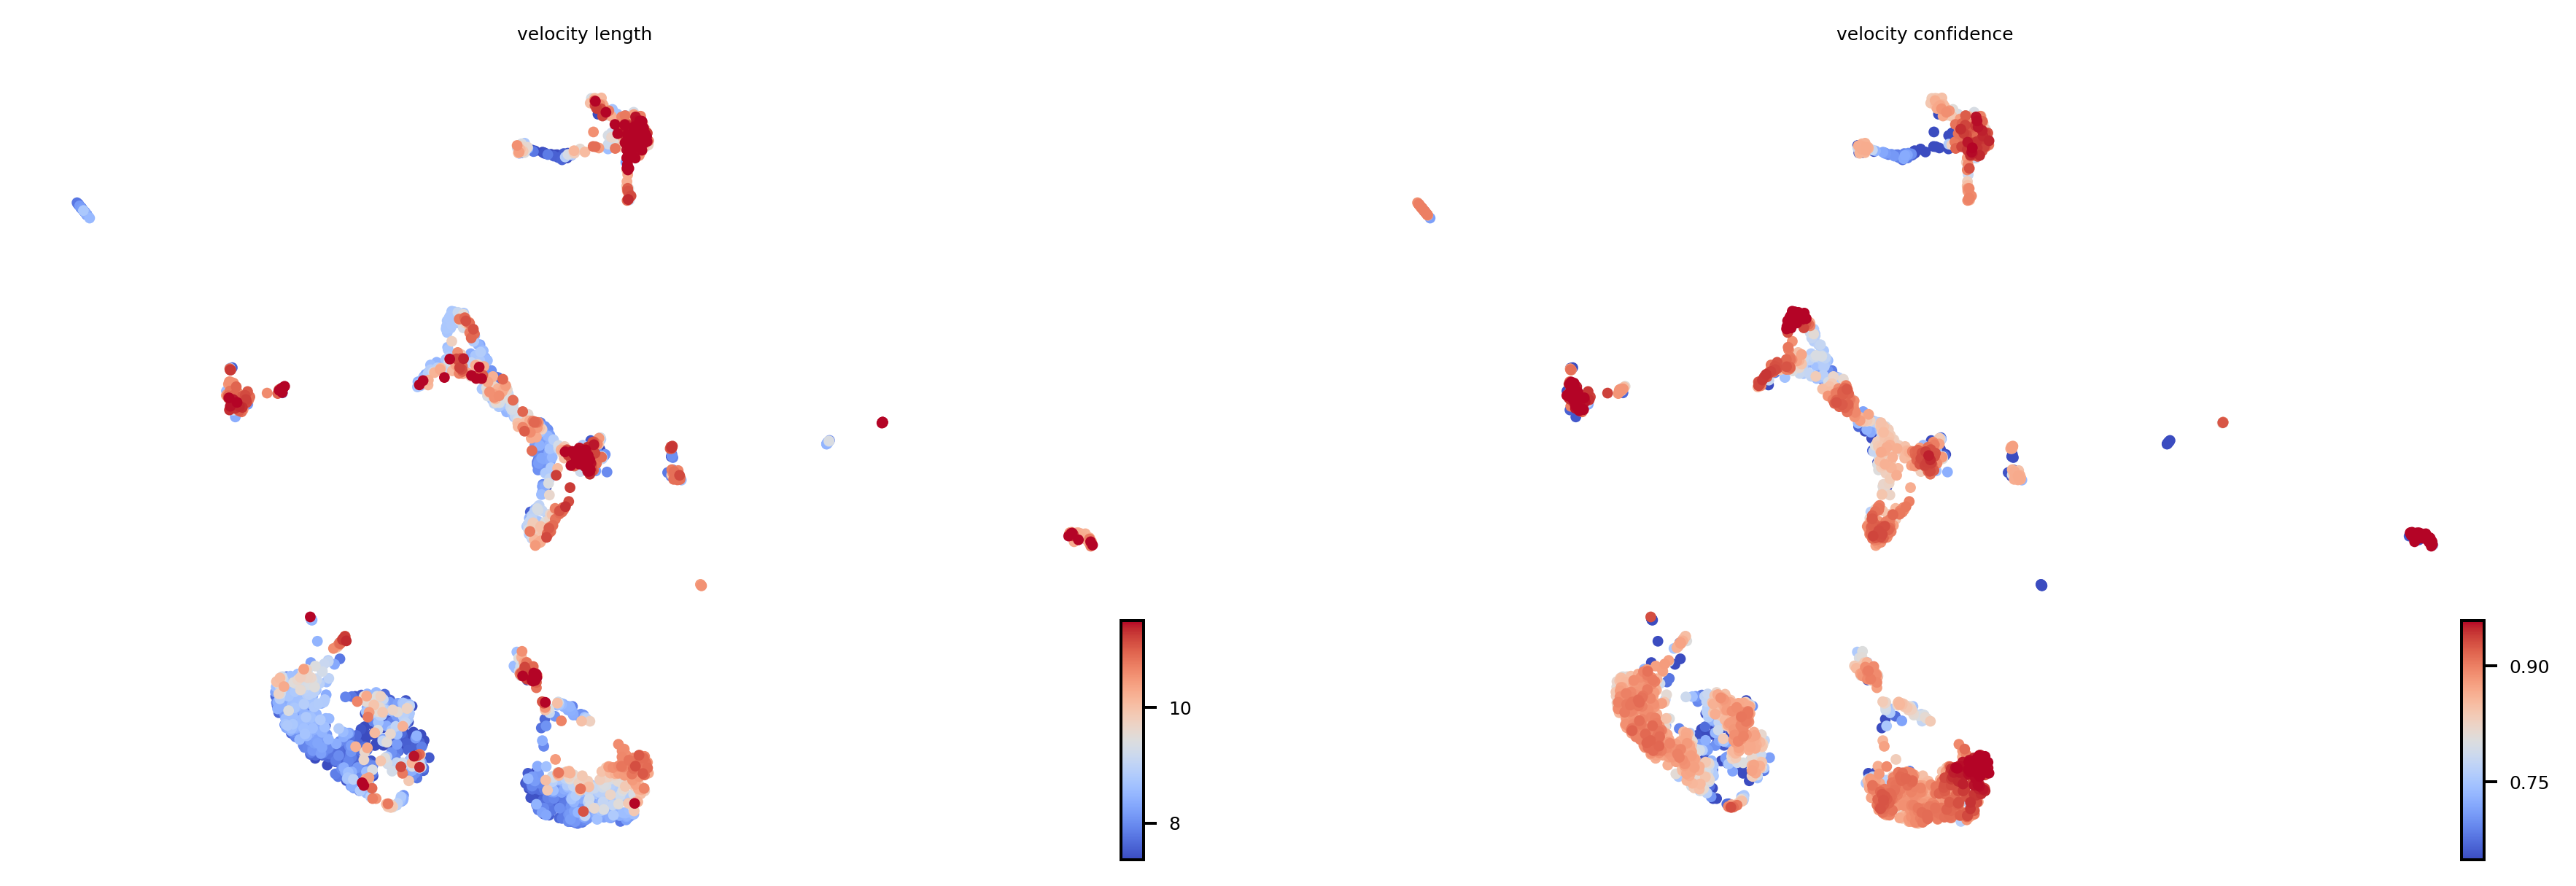

In [ ]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


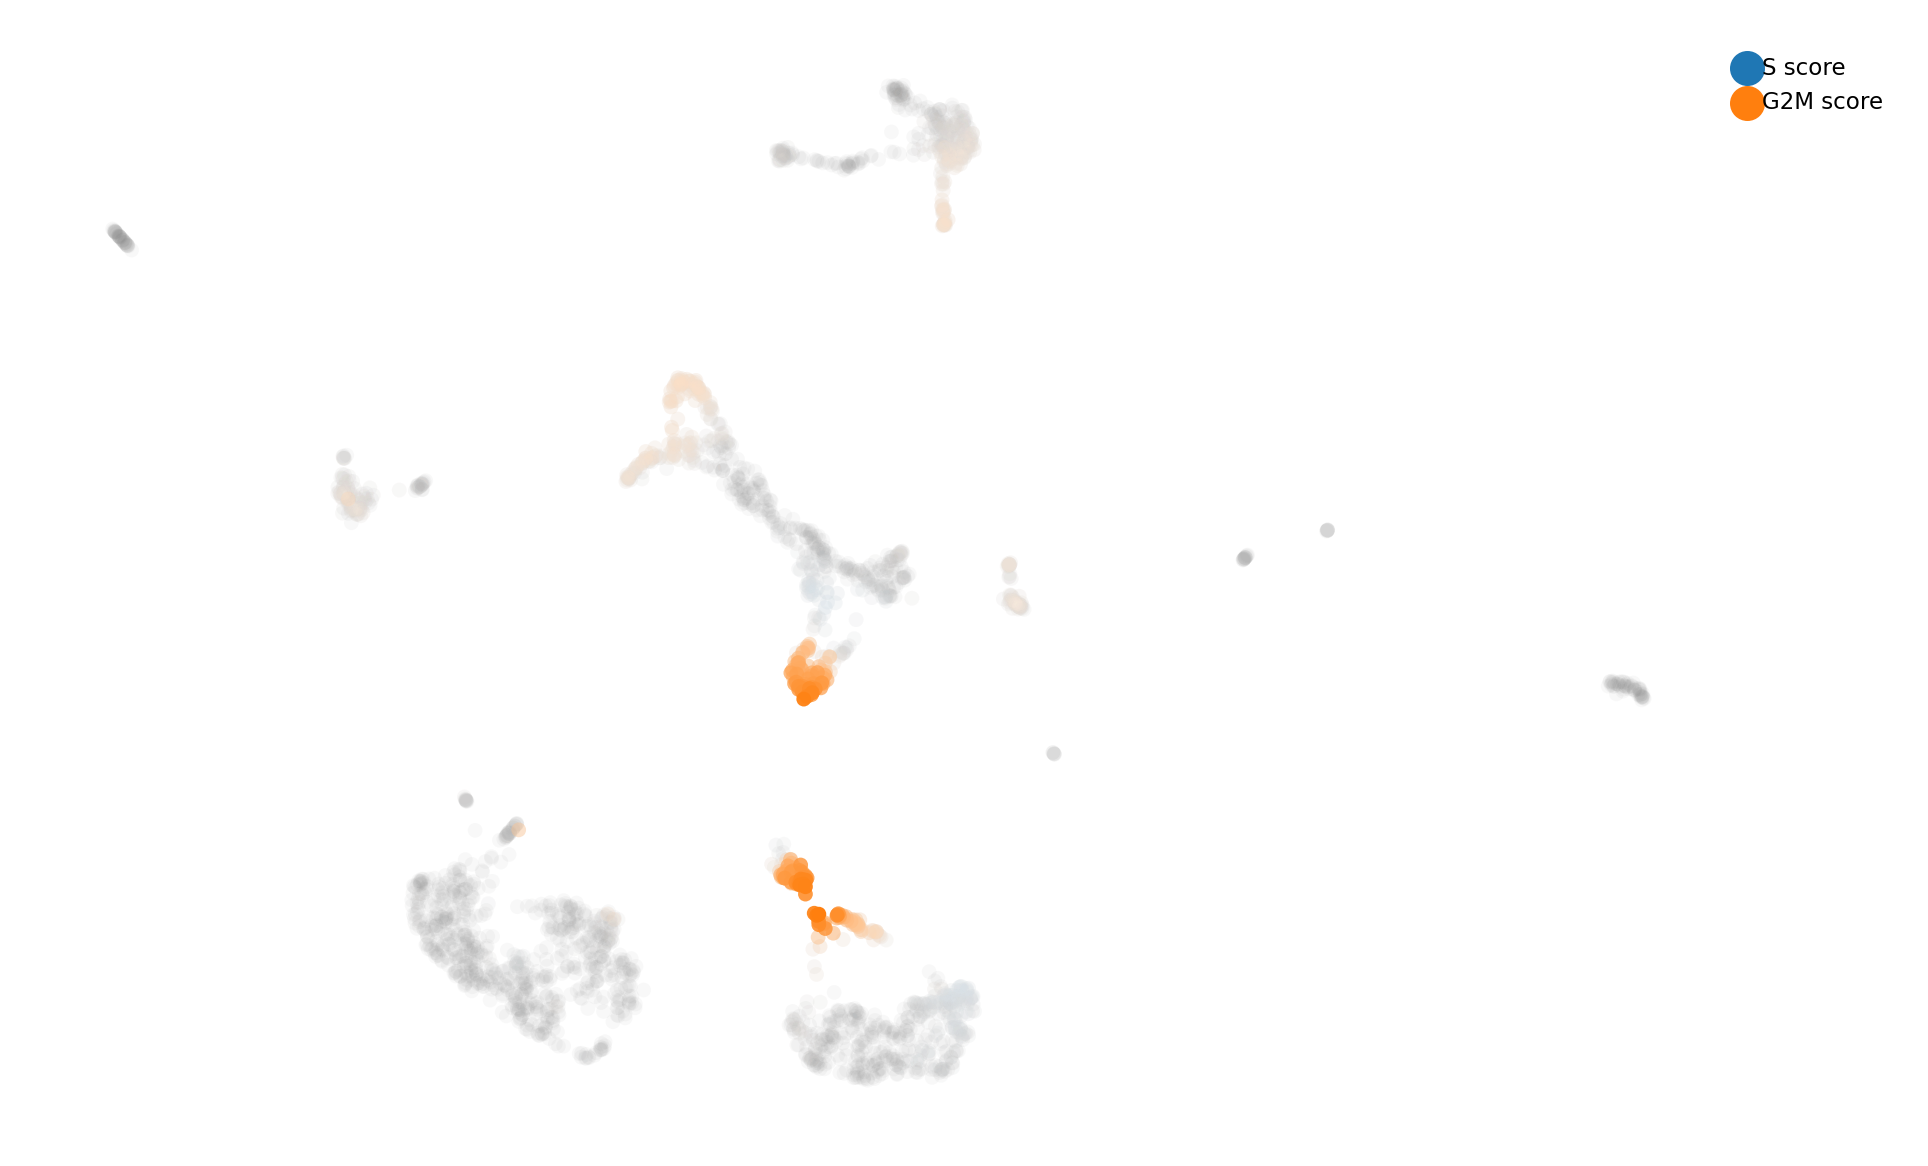

In [ ]:
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

In [ ]:
scv.tl.rank_velocity_genes(adata, groupby='CellType', min_corr=.3)

df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

/usr/local/lib/python3.10/dist-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


ranking velocity genes
    finished (0:00:15) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


<ipython-input-45-91643fd6e293>:3: DeprecationWarning: `scvelo.read_load.get_df` is deprecated since scVelo v0.2.4 and will be removed in a future version. Please use `scvelo.core.get_df` instead.
  df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])


CDM-1 fin bud-1       MM   NP-1 melanophore       SEP    CDM-2  \
0  fam189a1   adamts3      fus  lmf2b       rpl14     syt1a     lsp1   
1    scube1      ror2  prkab1b  grm8a       capzb     ano8b   nccrp1   
2      flt4    cldn7a    wfdc2  ank2b       rpl31  neurl1aa   fam69c   
3   efemp2a   fgfrl1a    ercc1   gnmt       rpl24    ptprfb  slc38a2   
4    senp3a      brd7    sart3  smad7        kita     clvs2    fgfr2   

  fin bud-2      CPM pigmented muscle  ...      PP     SC xanthophore  \
0     itih6   kif20a         tmem125b  ...  sept7a  psmb2      sephs1   
1     eif5b  slc1a3a           hecw1b  ...  megf10    fbl        sars   
2   golt1bb  slc29a2            vldlr  ...   gpnmb   sdha        tsr1   
3  slc35a3b    elf2b            cbx1a  ...   rpl38  nrd1a       rpl5a   
4      stx6   nccrp1        ppp1r14bb  ...  ptprea   tsr1      polr3e   

  iridiophore     DM-1      PM      muscle       CMM unindentified  \
0       tram2  bloc1s6   rps29      polr3e     med24       arrdc1a   
1       pax7a    chd4a   pole4       atoh8     mkrn4         pkp3a   
2      mrpl15      zyx  anxa1a       cbx1a     dgkaa         capn8   
3       rpl28   sema3d  rplp2l       ggt5a     itih6         oclna   
4       kat7b     aars   rps25  zgc:110626  mapk8ip3         tbx3a   

               DM-2  
0              tnk1  
1             capn8  
2  si:ch211-79k12.1  
3            sema3b  
4           racgap1  

[5 rows x 23 columns]

In [ ]:
# reload dataset
adata = sc.read_h5ad('/content/gdrive/MyDrive/singlecell_uribe/68h_Uribe_original_metadata/seurat_original_data_68HPF_v20230726.h5ad')

In [ ]:
adata

AnnData object with n_obs × n_vars = 2410 × 14679
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1.2', 'seurat_clusters', 'CellType', 'barcode', 'UMAP_1', 'UMAP_2', 'sample_batch', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'S_score', 'G2M_score', 'phase', 'clusters_gradients'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'spearmans_score', 'velocity_score'
    uns: 'CellType_colors', 'clusters_gradients_colors', 'neighbors', 'rank_velocity_genes', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity

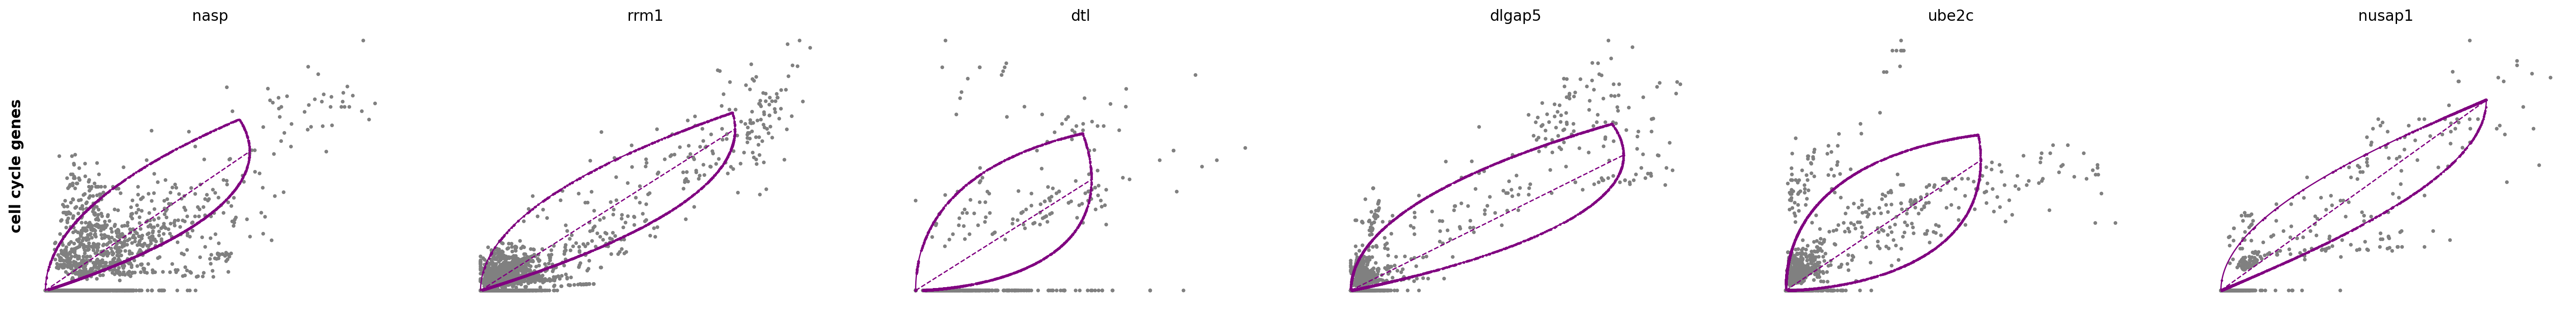

In [ ]:
scv.set_figure_params('scvelo')
s_genes, g2m_genes = scv.utils.get_phase_marker_genes(adata)
s_genes = scv.get_df(adata[:, s_genes], 'spearmans_score', sort_values=True).index
g2m_genes = scv.get_df(adata[:, g2m_genes], 'spearmans_score', sort_values=True).index

kwargs = dict(frameon=False, ylabel='cell cycle genes')
scv.pl.scatter(adata, list(s_genes[:3]) + list(g2m_genes[:3]), **kwargs)

In [ ]:
#make a list of all these cell cycle markers markers https://cdn.elifesciences.org/articles/60005/elife-60005-fig1-figsupp3-v1.jpg

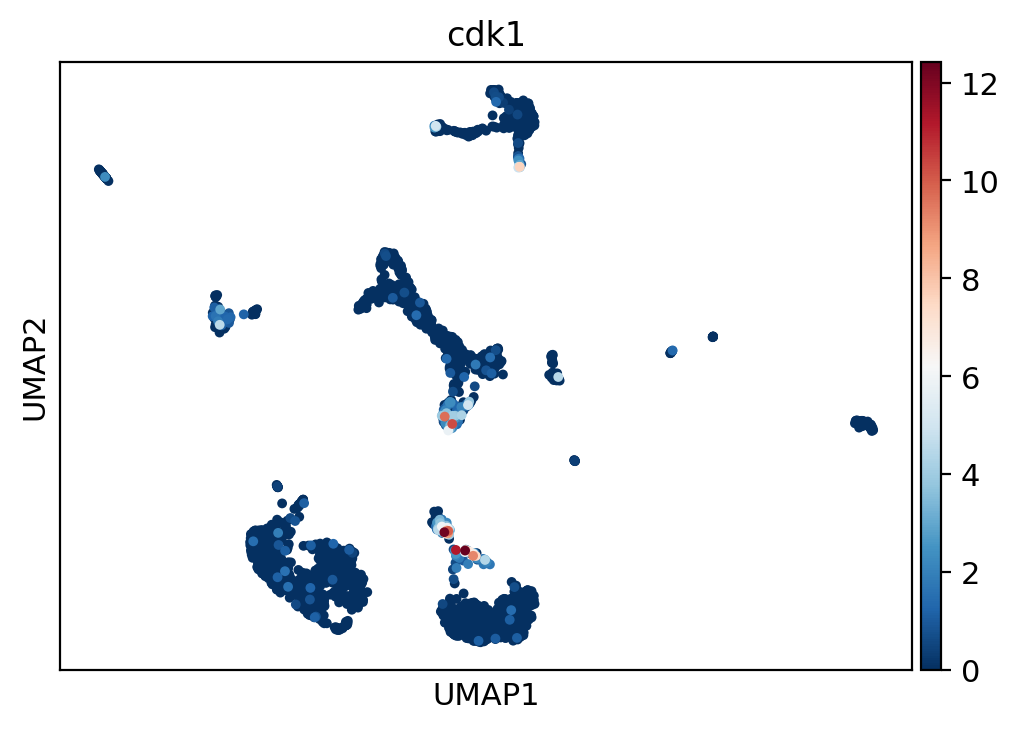

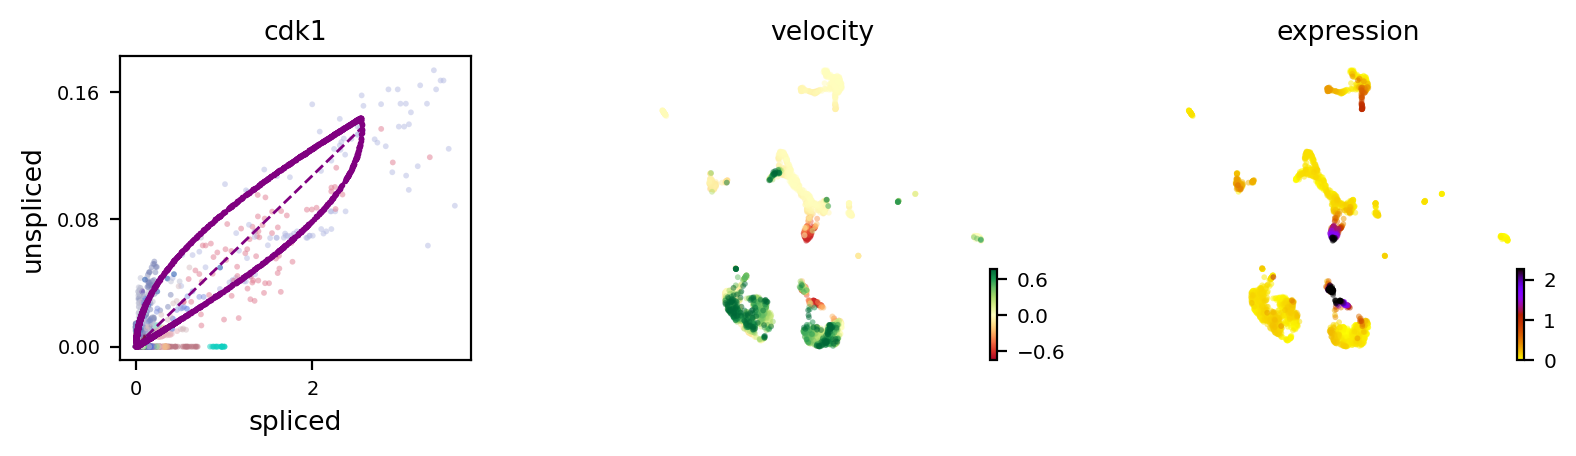

In [ ]:

sc.pl.umap(adata, color=['cdk1'])
scv.pl.velocity(adata, var_names=['cdk1'], color='CellType')

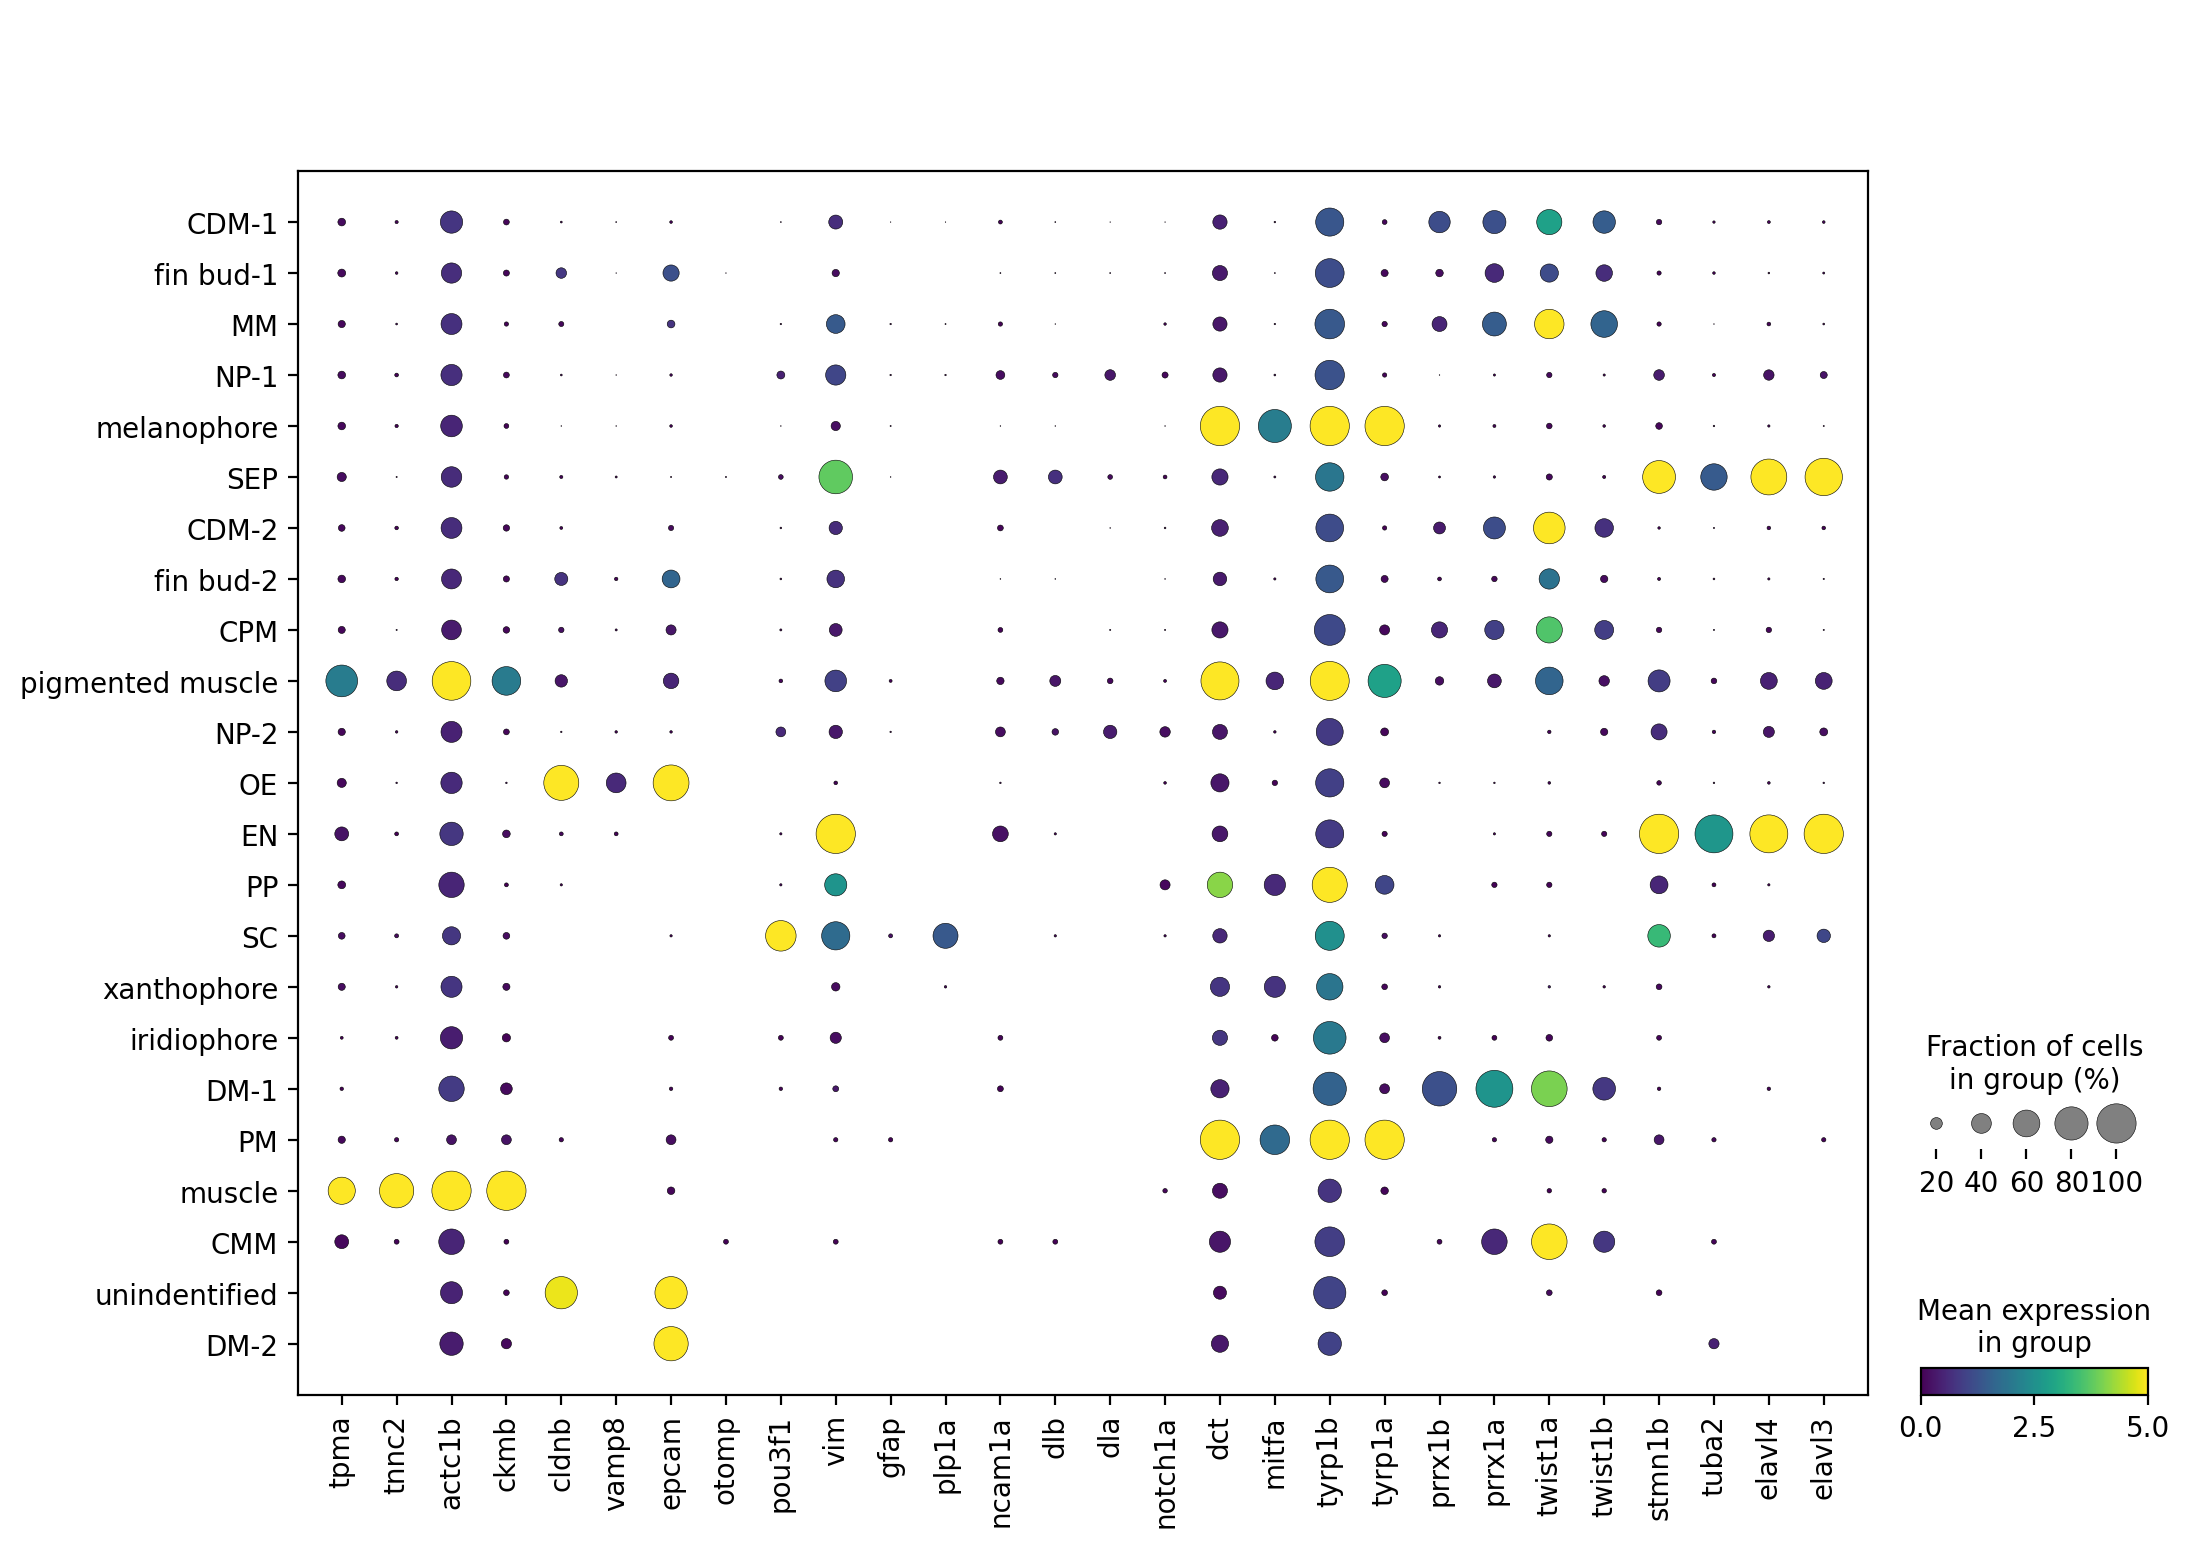

In [ ]:
var_names=['tpma', 'tnnc2', 'actc1b', 'ckmb', 'cldnb', 'vamp8','epcam', 'otomp', 'pou3f1', 'vim', 'gfap', 'plp1a', 'ncam1a', 'dlb', 'dla', 'notch1a', 'dct', 'mitfa', 'tyrp1b', 'tyrp1a', 'prrx1b', 'prrx1a', 'twist1a', 'twist1b', 'stmn1b', 'tuba2', 'elavl4', 'elavl3']

sc.pl.dotplot(adata, var_names=var_names, groupby='CellType', cmap= 'viridis', vmin=0, vmax=5 )

computing terminal states
    identified 3 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:09) --> added 
    'latent_time', shared time (adata.obs)


/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


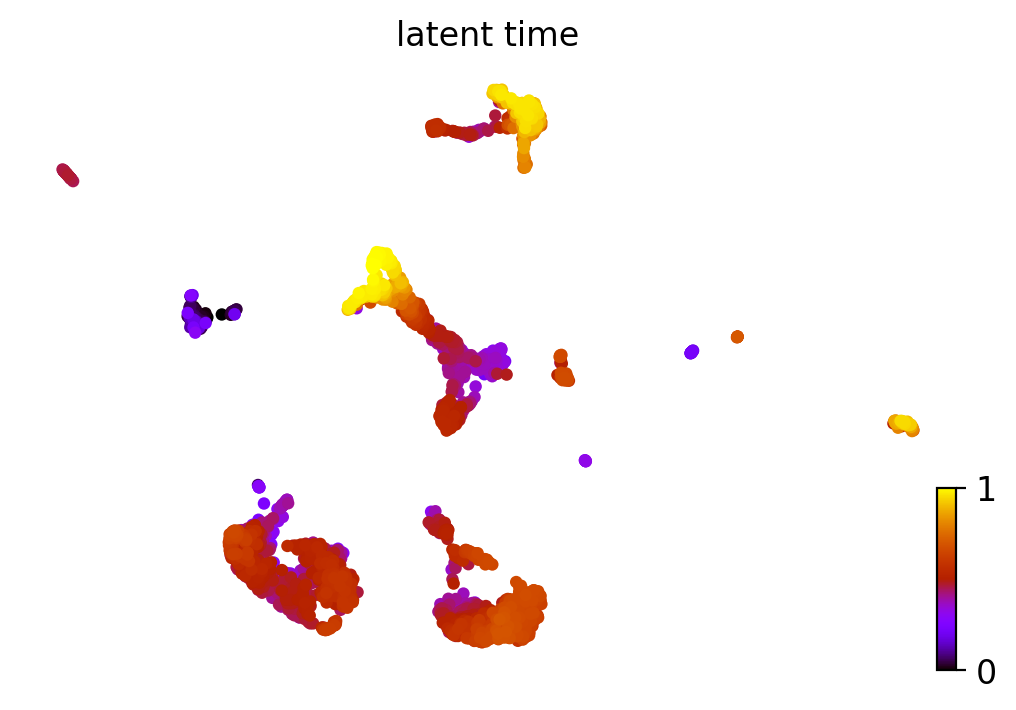

In [ ]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80, colorbar=True)

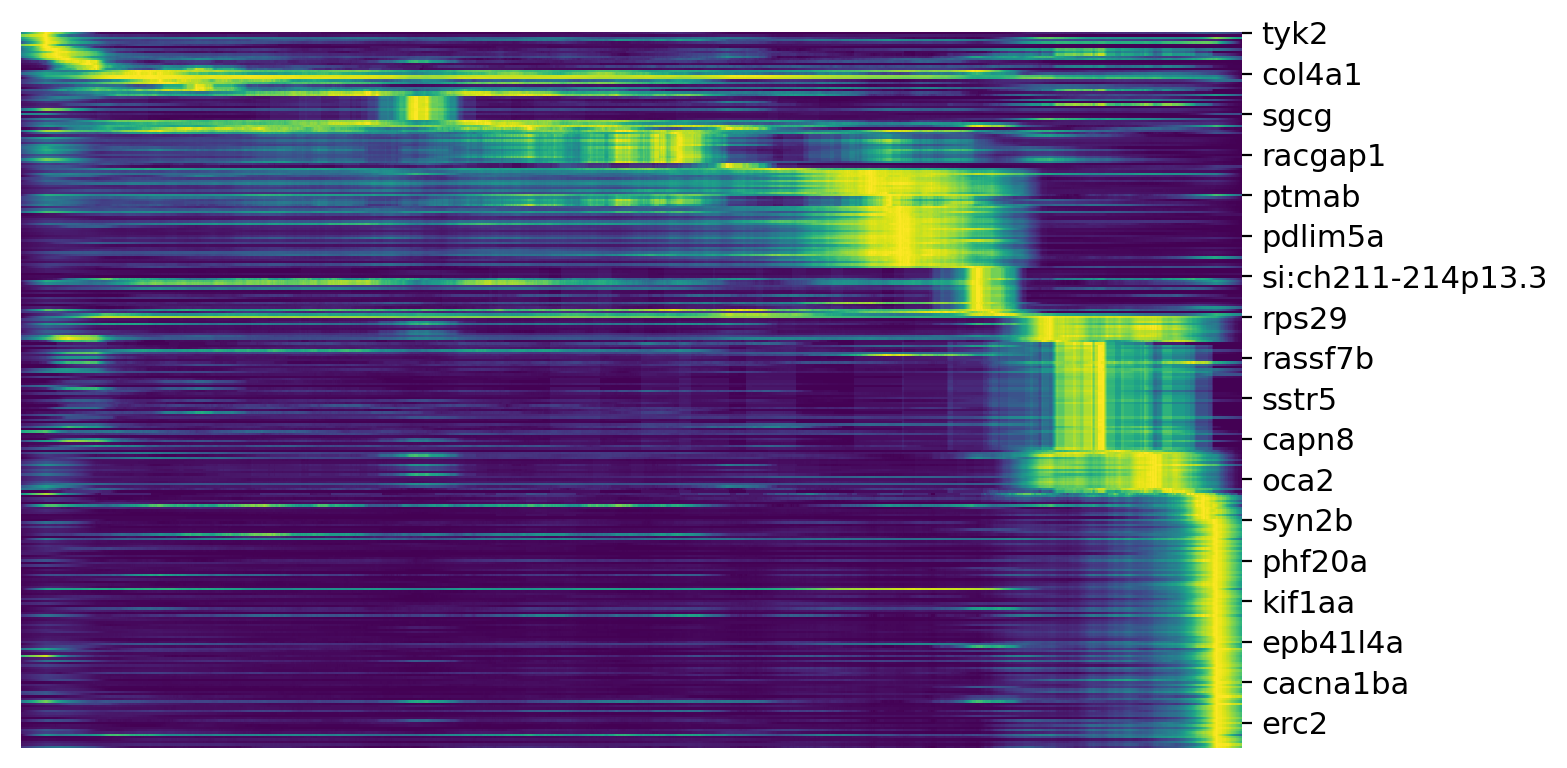

In [ ]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes,tkey='latent_time', n_convolve=100)

In [ ]:
#Phase portaits of marker genes and comparison for more different numbers of neighbors using logarithmized counts

k=[5,20,30,50,100,500]

scv.pl.scatter(adata, basis=["phox2bb", "sox10", "fgf13a", "elavl4"], use_raw=True)
for i in k:
    print( i," neighbours")
    scv.pp.moments(adata, n_neighbors=i)
    scv.pl.scatter(adata, basis=["phox2bb", "sox10", "fgf13a", "elavl4"], use_raw=False)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
scv.pp.moments(adata)

computing neighbors
    finished (0:00:20) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
adata

AnnData object with n_obs × n_vars = 2410 × 14679
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1.2', 'seurat_clusters', 'CellType', 'barcode', 'UMAP_1', 'UMAP_2', 'sample_batch', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr'
    uns: 'CellType_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [ ]:
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:10) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/2410 [00:00<?, ?cells/s]

    finished (0:03:28) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


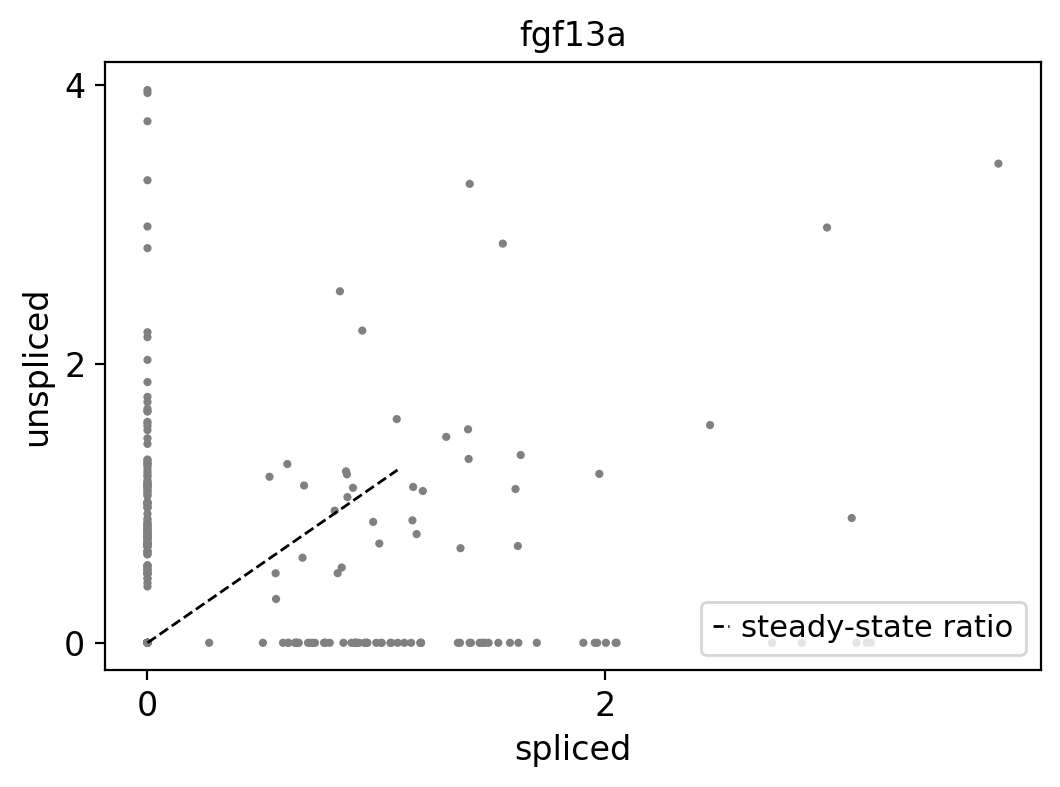

5  neighbours
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


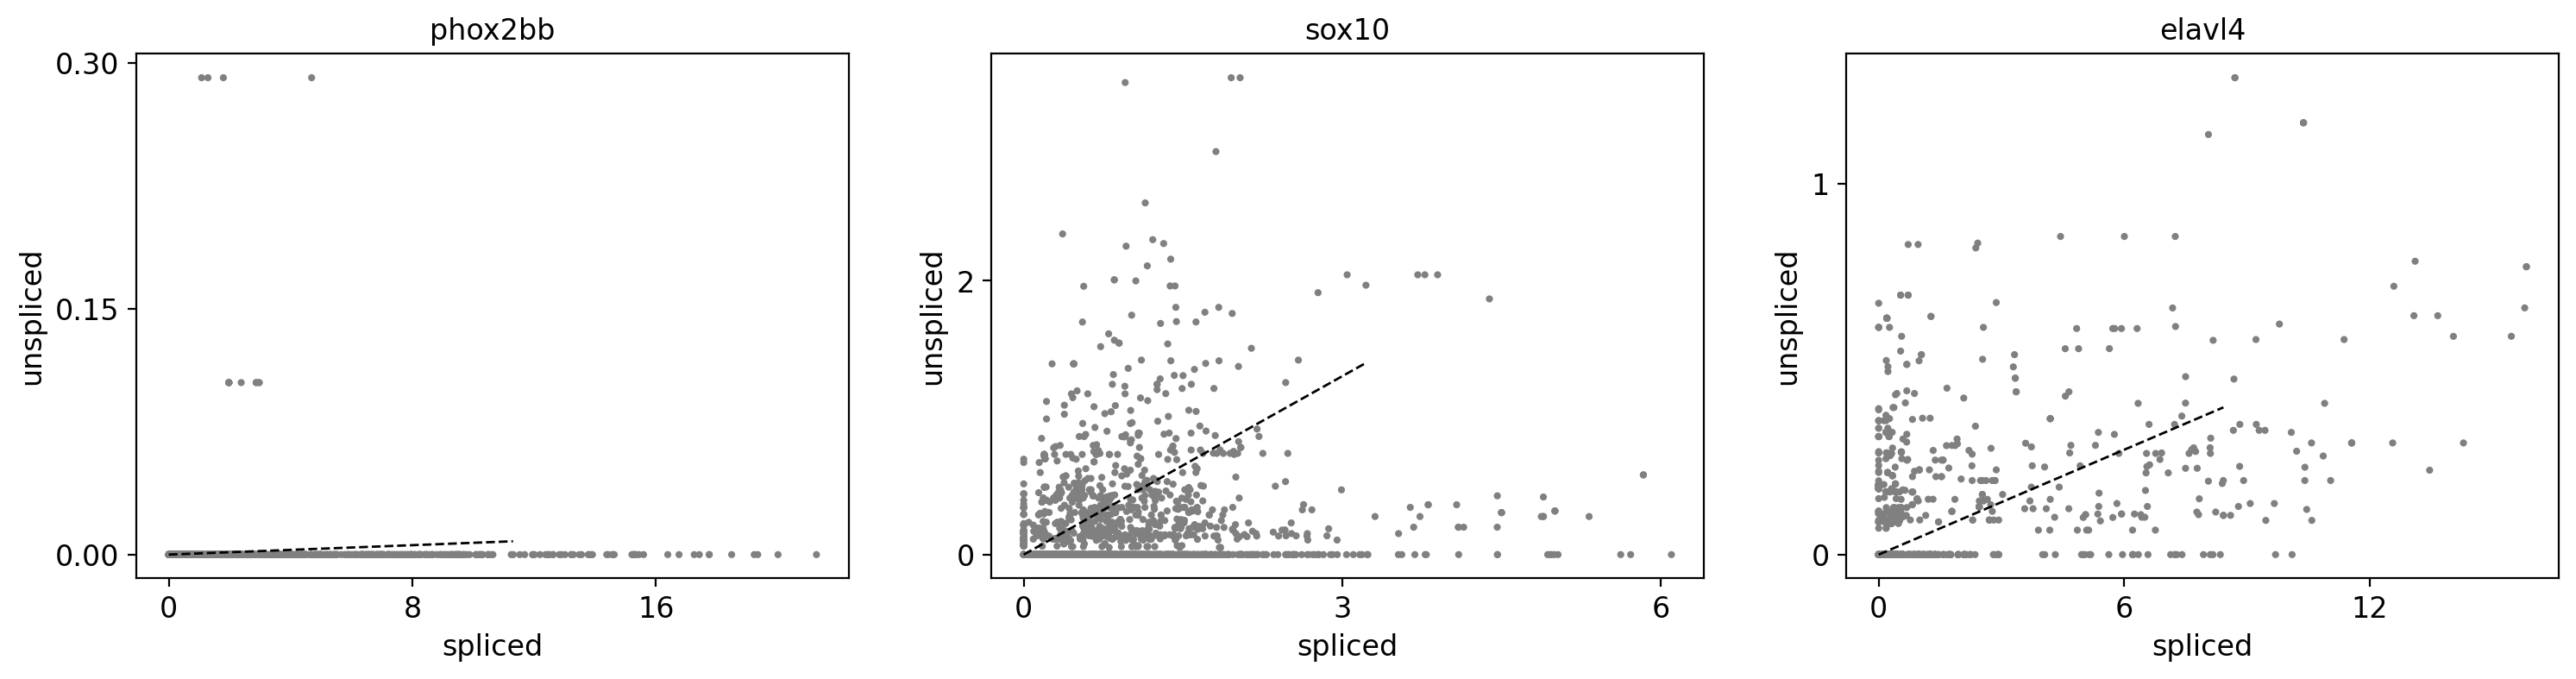

20  neighbours
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


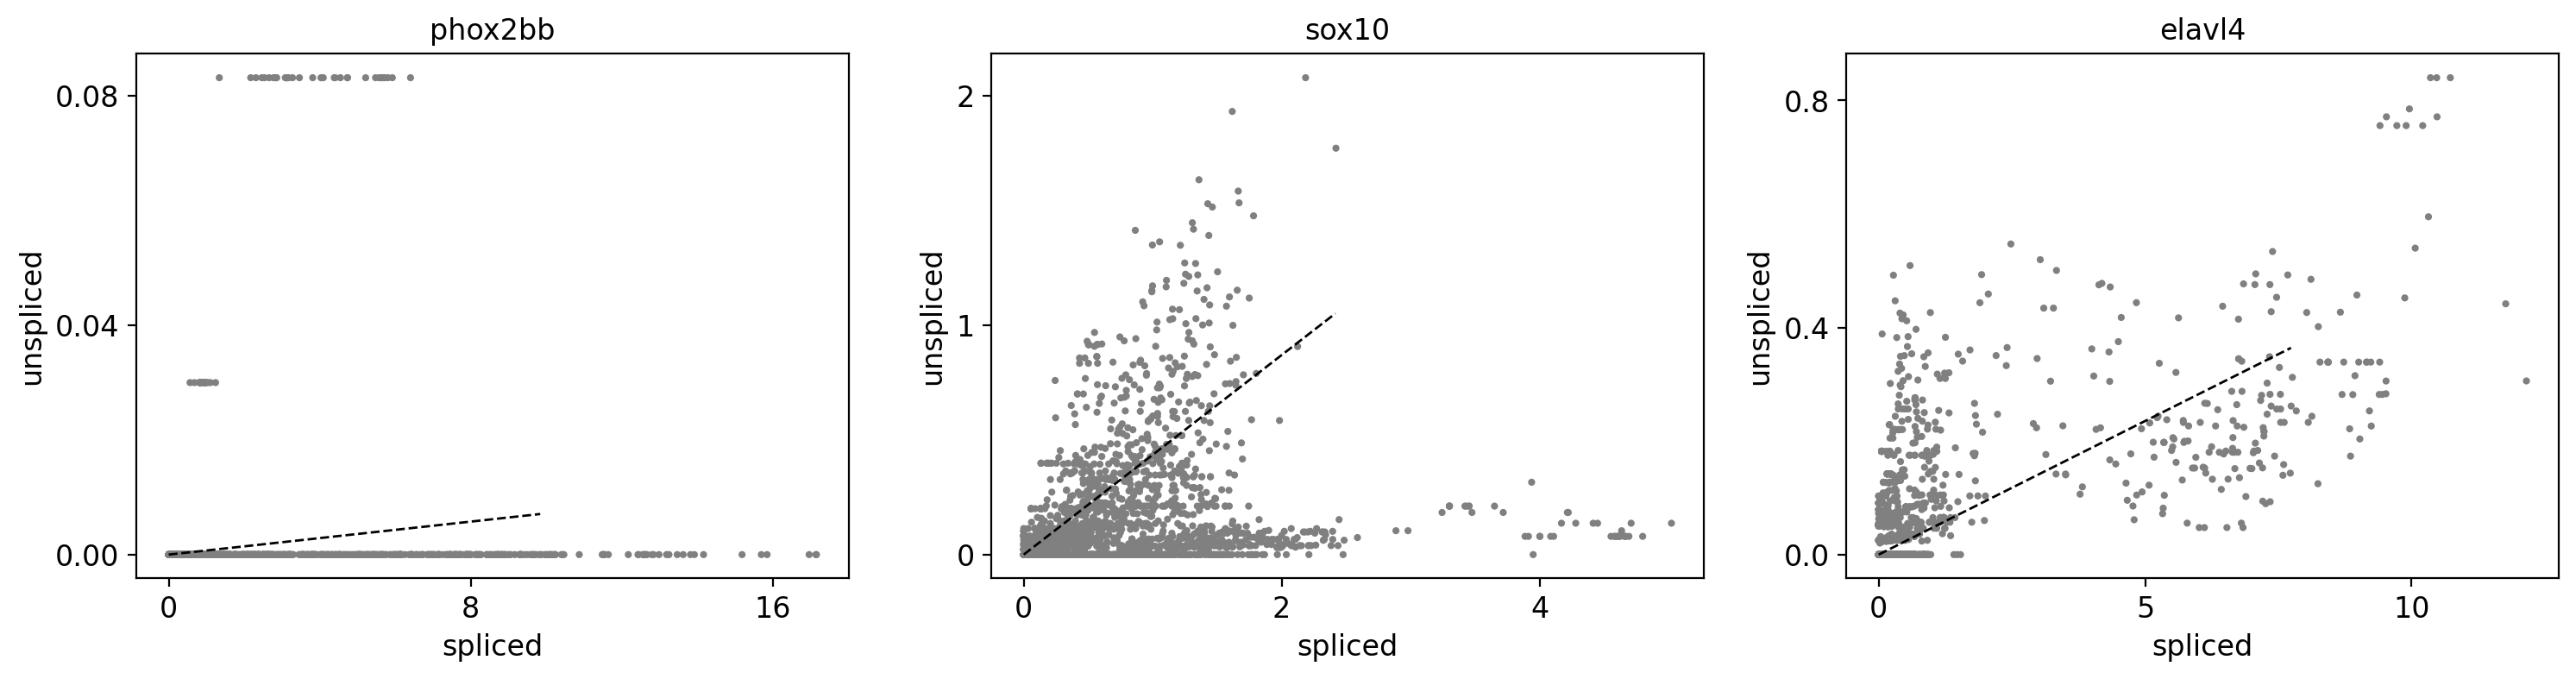

50  neighbours
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


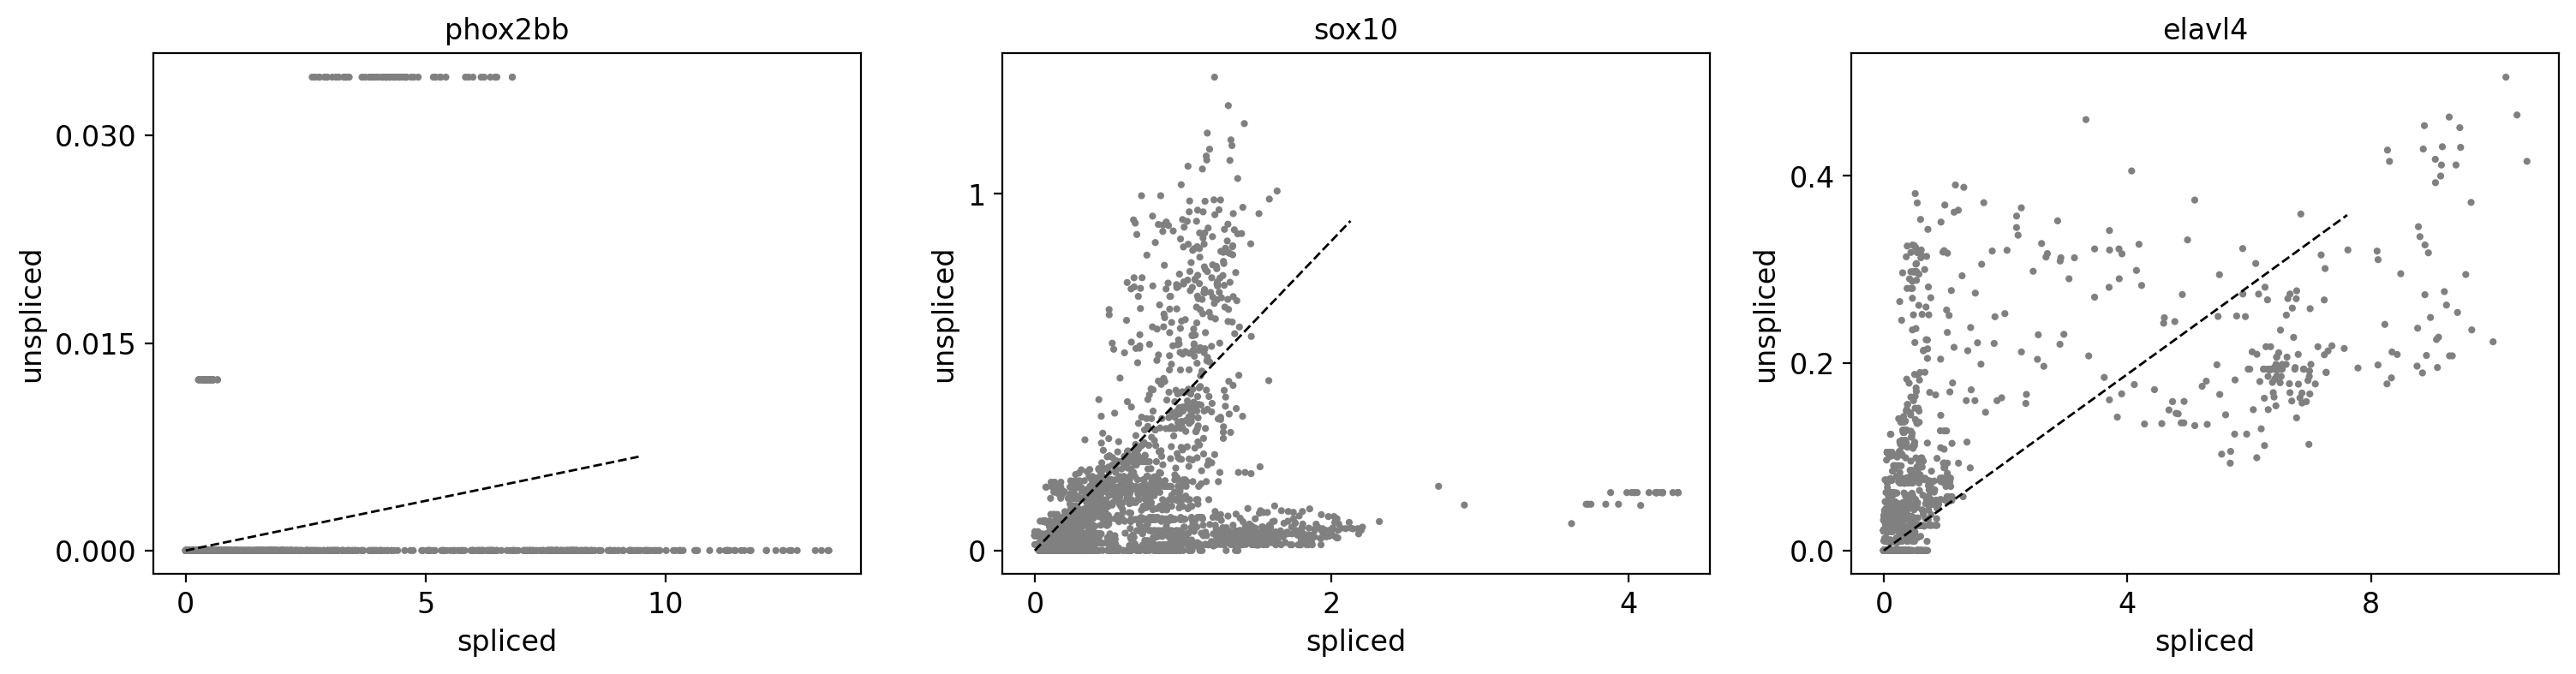

100  neighbours
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


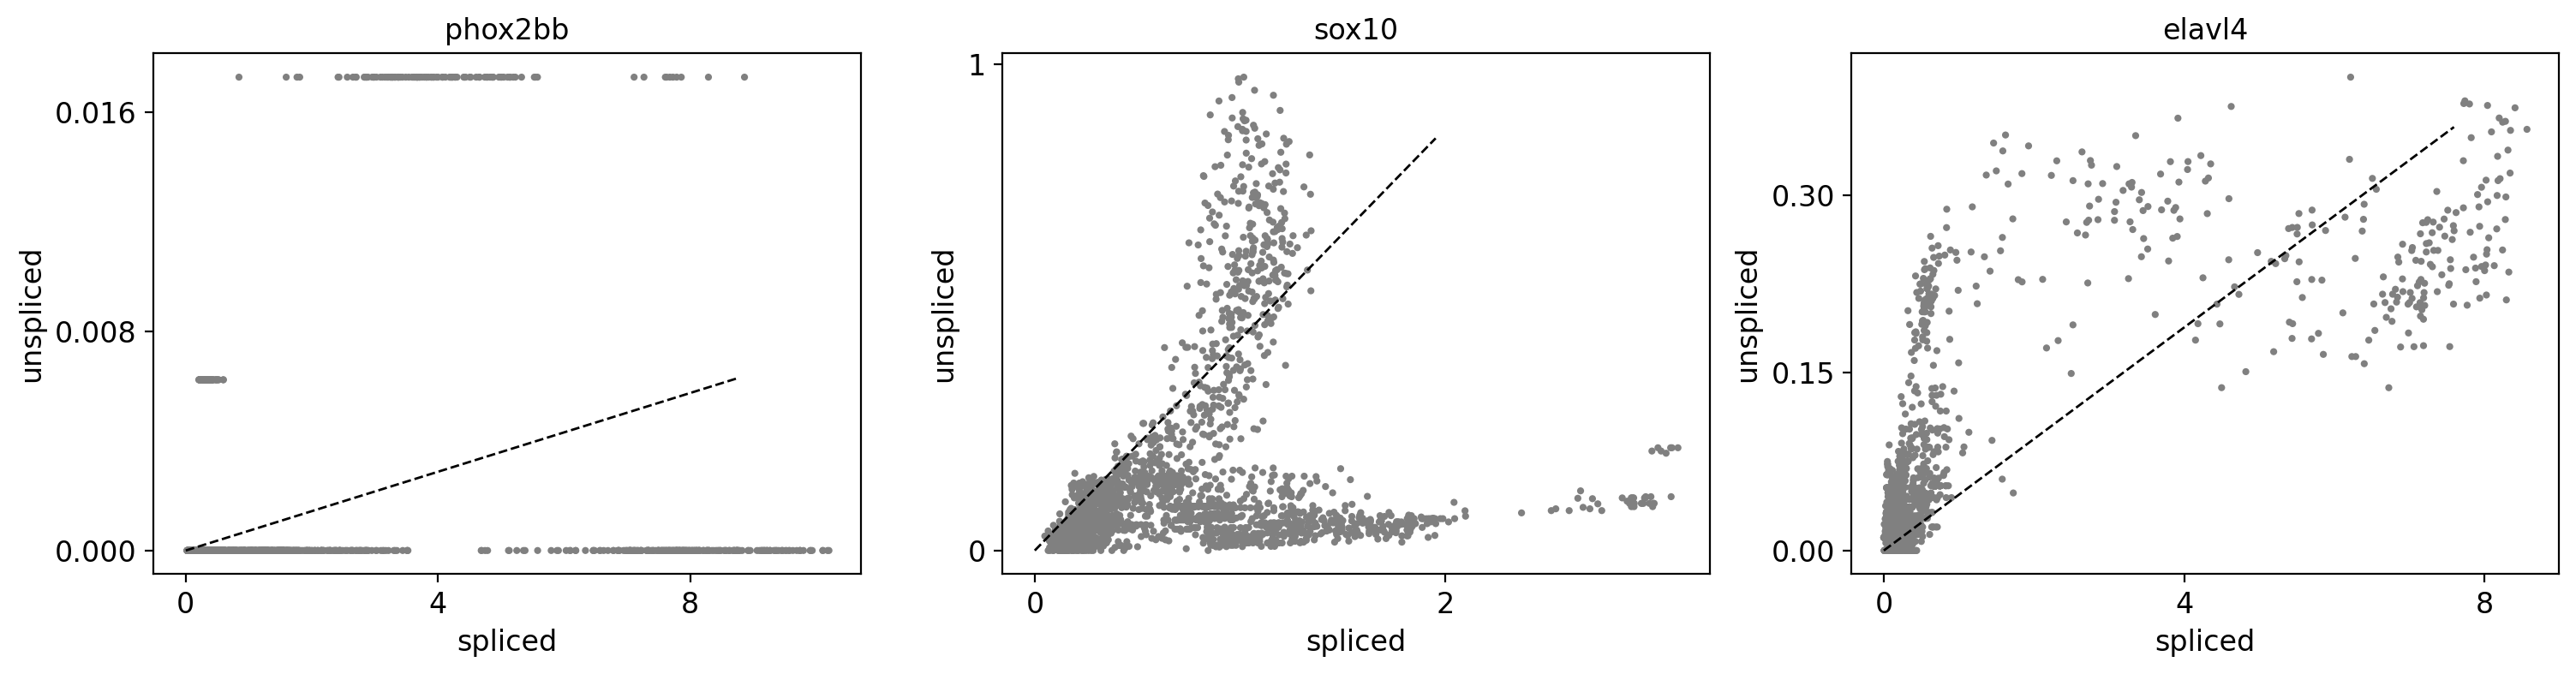

In [ ]:

#Phase portaits of marker genes and comparison for more different numbers of neighbors using raw counts

k=[5,20,50,100]

scv.pl.scatter(adata, basis="fgf13a", use_raw=True)
for i in k:
    print( i," neighbours")
    scv.pp.moments(adata, n_neighbors=i)
    scv.pl.scatter(adata, basis=["phox2bb", "sox10", "elavl4"], use_raw=False)

computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


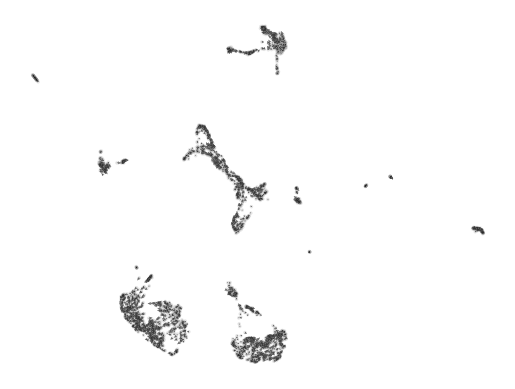

In [ ]:
scv.pl.velocity_embedding(adata, basis='umap', frameon=False)

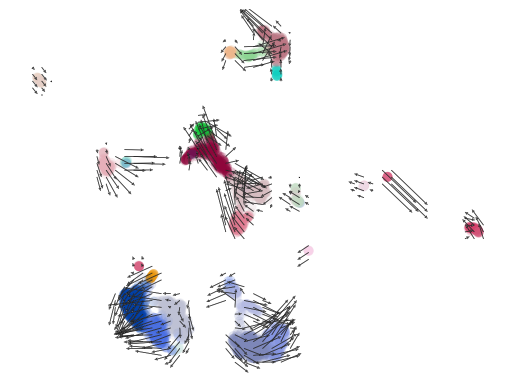

In [ ]:
scv.pl.velocity_embedding_grid(adata, basis='umap', color='CellType', title='', scale=0.25)


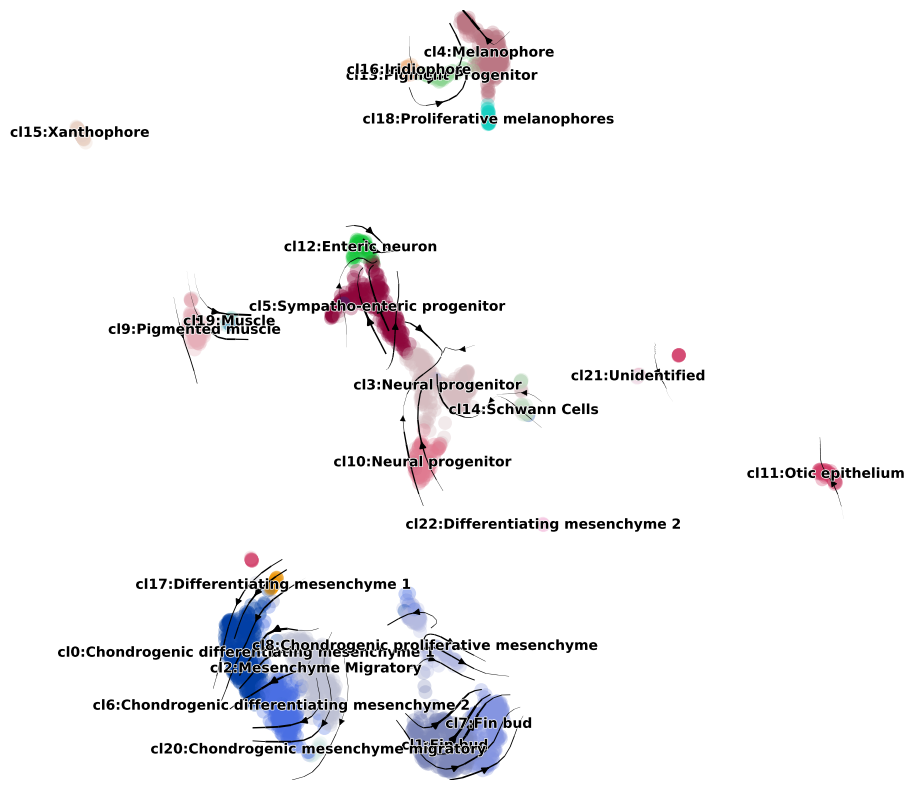

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['CellType'], title='', figsize=(10,10), fontsize=3)

Here we show how to identify highly dynamic genes, compute a measure of coherence among neighboring cells in terms of velocity, and perform pseudotime inference. Using the pseudotime trajectory, we can identify predicted ancestors of individual cells, and we can orient the directionality of partition-based graph abstractions (PAGA).


In [ ]:

scv.tl.rank_velocity_genes(adata, groupby='CellType', min_corr=.3)

df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head(20)

ranking velocity genes


/usr/local/lib/python3.10/dist-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:14) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


<ipython-input-58-b02dbf849452>:3: DeprecationWarning: `scvelo.read_load.get_df` is deprecated since scVelo v0.2.4 and will be removed in a future version. Please use `scvelo.core.get_df` instead.
  df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])


cl0:Chondrogenic differentiating mesenchyme 1 cl1:Fin bud  \
0                                        antxr2a      adgrg6   
1                                         fhod3b        xbp1   
2                                         efna2a       ebf3a   
3                                        adgrl2a     hapln1a   
4                                          efcc1     fgfbp2b   
5                                         scube1       itga9   
6                                      serpinh1b     kcnma1a   
7                                           lhfp       tbx5a   
8                                         fam65c     mical2b   
9                                         dchs1a      klf12a   
10                                         fgfr2       lpar1   
11                                        pdlim1       sulf1   
12                                         fstl3       neo1a   
13                                        hoxb3a     limch1b   
14                                        pcdh7b    col11a1a   
15                                       efemp2a        MDFI   
16                                          oafa        wwp2   
17                                       pard6gb     sema3bl   
18                                    CU896691.1      sema5a   
19                                       hsp70.2       acana   

   cl2:Mesenchyme Migratory cl3:Neural progenitor    cl4:Melanophore  \
0                 ms4a17a.7                 grm8a            syngr2b   
1                    lzts2b                ncam1a   si:dkey-250k10.4   
2                     cd81a               afap1l2     CABZ01048402.2   
3                    col5a1                   ntm             ndufb8   
4                  col12a1b                 opcml           atp6v0e1   
5                      flna                 cadm3  si:ch211-241j12.3   
6                     actn1                 rtn1a            slc37a2   
7                   fam107b               kif26ba              uqcrb   
8                    pdgfra                 maptb             atp5ia   
9                       f3b               hsp70.1              opn4b   
10                  colec12                cadm1b               dmtn   
11                     cd99                  cdh4             ppfia2   
12                    mtss1                 tshz1             agtrap   
13                    etv5a                 cntfr              fmn2a   
14                   grinab                sorbs3              cemip   
15                    fhl3a              slc38a11               evla   
16                    psat1                   ret             ndufb2   
17                    clic2                epb41a         BX571715.1   
18                      txn                syt11a         rab11fip1b   
19                    ulk1a                arvcfb              gpd1c   

   cl5:Sympatho-enteric progenitor  \
0                            dpp6b   
1                            map6a   
2                            mpp3a   
3                           nlgn4a   
4                           ccdc92   
5                             eno2   
6                            kcnd2   
7                            astn1   
8                          atp2b3a   
9                           dnajc6   
10                            EML5   
11                           gphnb   
12                           chl1b   
13                            erc2   
14                        neurl1aa   
15                         jakmip2   
16                         snap25a   
17                           glrbb   
18                          parp6b   
19                         galnt14   

   cl6:Chondrogenic differentiating mesenchyme 2 cl7:Fin bud  \
0                                        hsp70.2      f13a1b   
1                                          fbln2     mical2b   
2                                          foxp4      ptgdsa   
3                                        hsp70.1     sema5bb   
4                         

In [ ]:
df_enteric_neuron = df['cl12:Enteric neuron']
df_enteric_neuron

0         ank1b
1         nbeaa
2        galnt9
3        dscamb
4         astn1
        ...    
95    smarcad1b
96        nrp1a
97        ptmab
98       nlgn4a
99         dpf1
Name: cl12:Enteric neuron, Length: 100, dtype: object

In [ ]:
# plot velocity of a selected gene
scv.pl.velocity(adata, ['fgf13a'], ncols=2, color='CellType', figsize=(10,6))

NameError: ignored

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


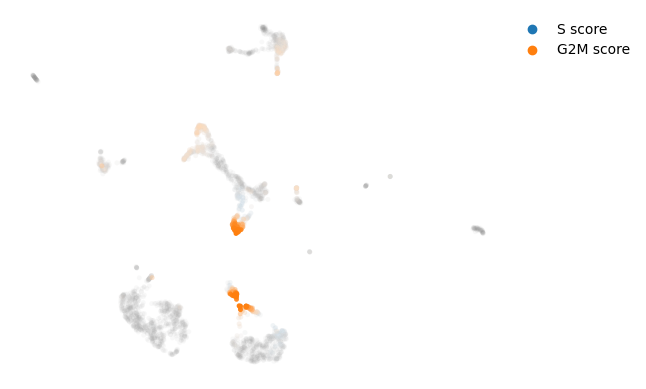

In [ ]:
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

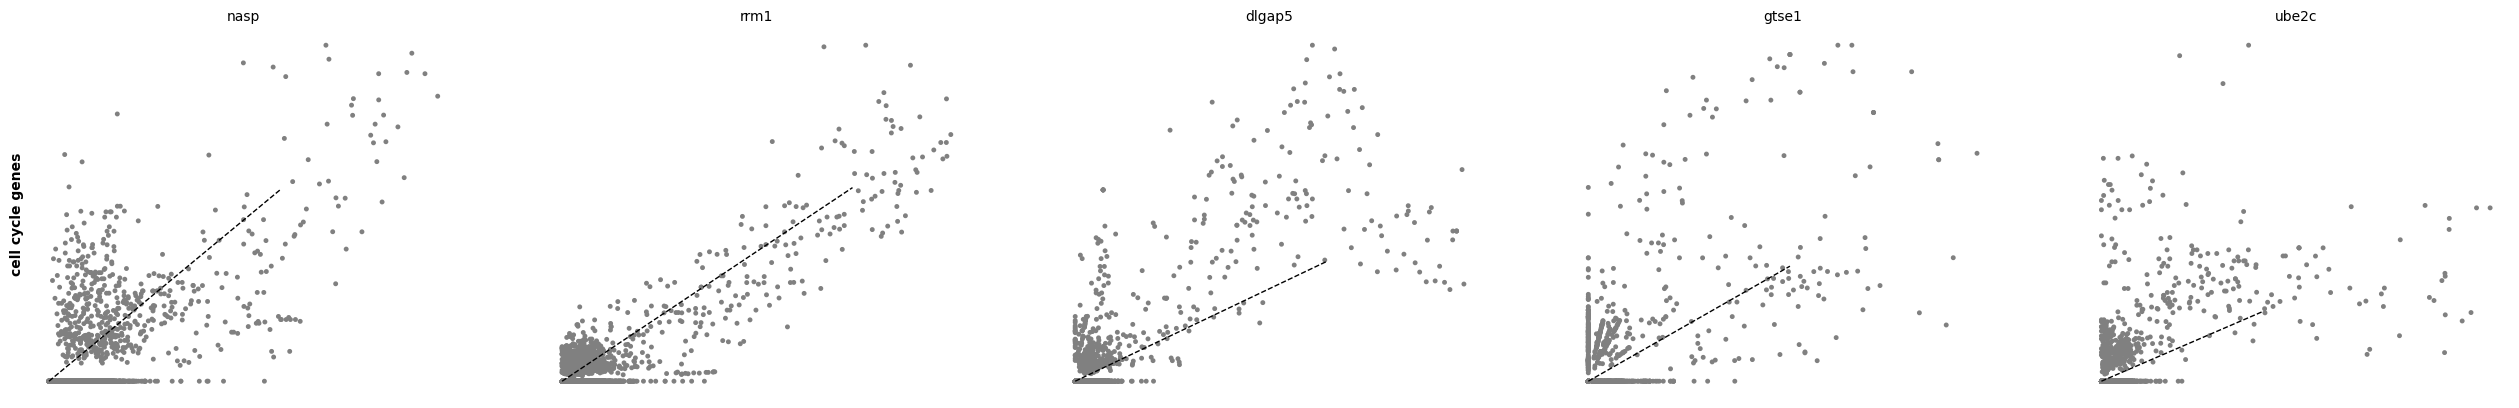

In [ ]:
s_genes, g2m_genes = scv.utils.get_phase_marker_genes(adata)
s_genes = scv.get_df(adata[:, s_genes], 'spearmans_score', sort_values=True).index
g2m_genes = scv.get_df(adata[:, g2m_genes], 'spearmans_score', sort_values=True).index

kwargs = dict(frameon=False, ylabel='cell cycle genes')
scv.pl.scatter(adata, list(s_genes[:2]) + list(g2m_genes[:3]), **kwargs)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/usr/local/lib/python3.10/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


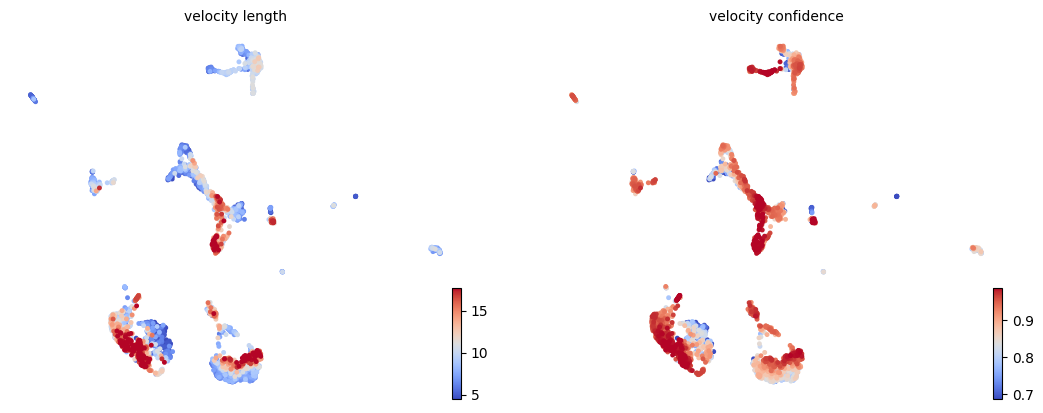

In [ ]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95])

In [ ]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

In [ ]:
adata.write('/content/gdrive/MyDrive/singlecell_uribe/seurat_original_data_68HPF_scvelo_moments.h5ad')

In [ ]:
!pip freeze > scvelo_google_colab_package_versions.txt

In [ ]:
# this is needed due to a current bug - bugfix is coming soon.
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='CellType')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


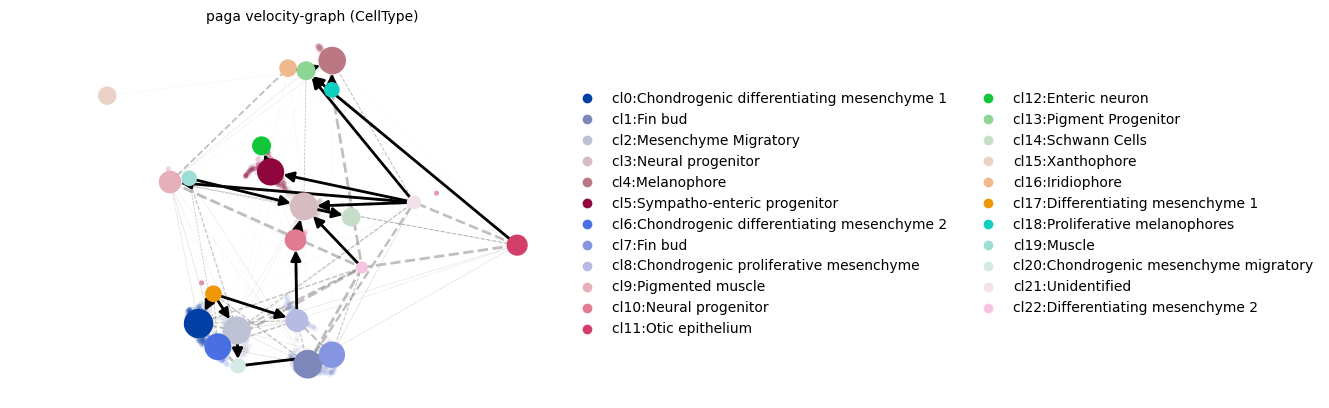

In [ ]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5)

In [ ]:
df = adata.obs.groupby('CellType')[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

In [ ]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')


In [ ]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/2 cores)


  0%|          | 0/2410 [00:00<?, ?cells/s]

    finished (0:00:12) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


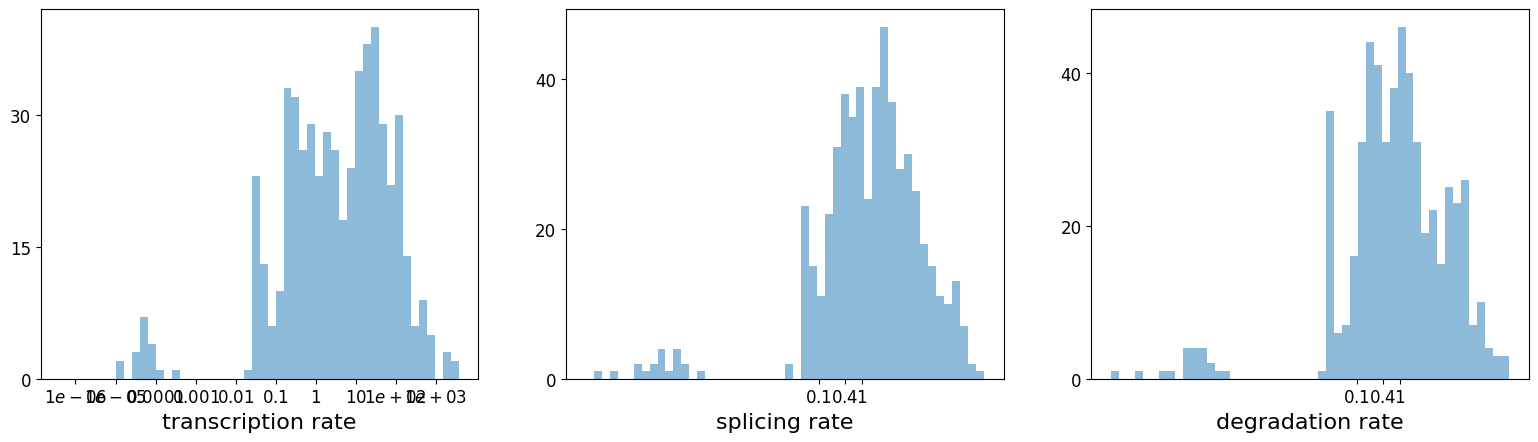

fit_alpha   fit_beta  fit_gamma      fit_t_  fit_scaling  fit_std_u  \
tbk1      0.050000   0.050000   0.050000  367.843149     1.650000   1.000000   
crebl2    0.050000   0.050000   0.050000  367.843149     1.650000   1.000000   
rpl18a   60.812240  31.590774   0.592003    4.439339     0.005633   0.218985   
ost4      6.386009   4.784434   0.560302    0.740860     1.732500   1.000000   
tmem214   0.050000   0.050000   0.050000  367.843149     1.650000   1.000000   

         fit_std_s  fit_likelihood  fit_u0  fit_s0  fit_pval_steady  \
tbk1      1.000000        0.000000     0.0     0.0         1.000000   
crebl2    1.000000        0.000000     0.0     0.0         1.000000   
rpl18a   18.790994        0.114621     0.0     0.0         0.499039   
ost4      1.000000        0.001705     0.0     0.0         1.000000   
tmem214   1.000000        0.000000     0.0     0.0         1.000000   

         fit_steady_u  fit_steady_s  fit_variance  fit_alignment_scaling  \
tbk1              0.0      0.000000  2.019484e-28              20.000000   
crebl2            0.0      0.000000  2.019484e-28              20.000000   
rpl18a            2.0     59.344828  2.156460e+00               2.716288   
ost4              0.0      0.000000  2.069658e+00               0.206523   
tmem214           0.0      0.000000  8.077936e-28              20.000000   

           fit_r2  
tbk1    -0.019025  
crebl2   0.033251  
rpl18a   0.056952  
ost4     0.095342  
tmem214  0.016072

In [ ]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

In [ ]:
adata

AnnData object with n_obs × n_vars = 2410 × 14679
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1.2', 'seurat_clusters', 'CellType', 'barcode', 'UMAP_1', 'UMAP_2', 'sample_batch', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'gene_count_corr', 'fit_r2', 'velocity_genes'
    uns: 'CellType_colors', 'recover_dynamics', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap'
    varm: 'loss'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'fit_t', 'fit_tau', 'fit_tau_', 'Ms', 'Mu

In [ ]:
#The dynamical model recovers the latent time of the underlying cellular processes. This latent time represents the cell’s internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics.

scv.tl.latent_time(adata)


KeyError: ignored

In [ ]:
print(adata.obs.keys())

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt',
       'RNA_snn_res.1.2', 'seurat_clusters', 'CellType', 'barcode', 'UMAP_1',
       'UMAP_2', 'sample_batch', 'Clusters', '_X', '_Y',
       'initial_size_unspliced', 'initial_size_spliced', 'initial_size',
       'n_counts', 'velocity_self_transition', 'root_cells', 'end_points',
       'velocity_pseudotime', 'latent_time'],
      dtype='object')


In [ ]:
adata.obs['latent_time'].dtype

dtype('float64')

In [ ]:
np.isnan(adata.obs['latent_time']).any()

True

In [ ]:
num_nan_values = adata.obs['latent_time'].isna().sum()
print("Number of NaN values in 'latent_time' column:", num_nan_values)

Number of NaN values in 'latent_time' column: 2410


In [ ]:
scv.tl.latent_time(adata)
scv.pl.scatter(df1['latent_time'], color= 'latent_time')

computing latent time using root_cells as prior
    finished (0:00:03) --> added 
    'latent_time', shared time (adata.obs)


KeyError: ignored

In [ ]:
adata

AnnData object with n_obs × n_vars = 2410 × 14679
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1.2', 'seurat_clusters', 'CellType', 'barcode', 'UMAP_1', 'UMAP_2', 'sample_batch', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'gene_count_corr', 'fit_r2', 'velocity_genes'
    uns: 'CellType_colors', 'recover_dynamics', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap'
    varm: 'loss'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'fit_t', 'fit_tau', 'fit_tau_', 'Ms', 'Mu

In [ ]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

ValueError: ignored

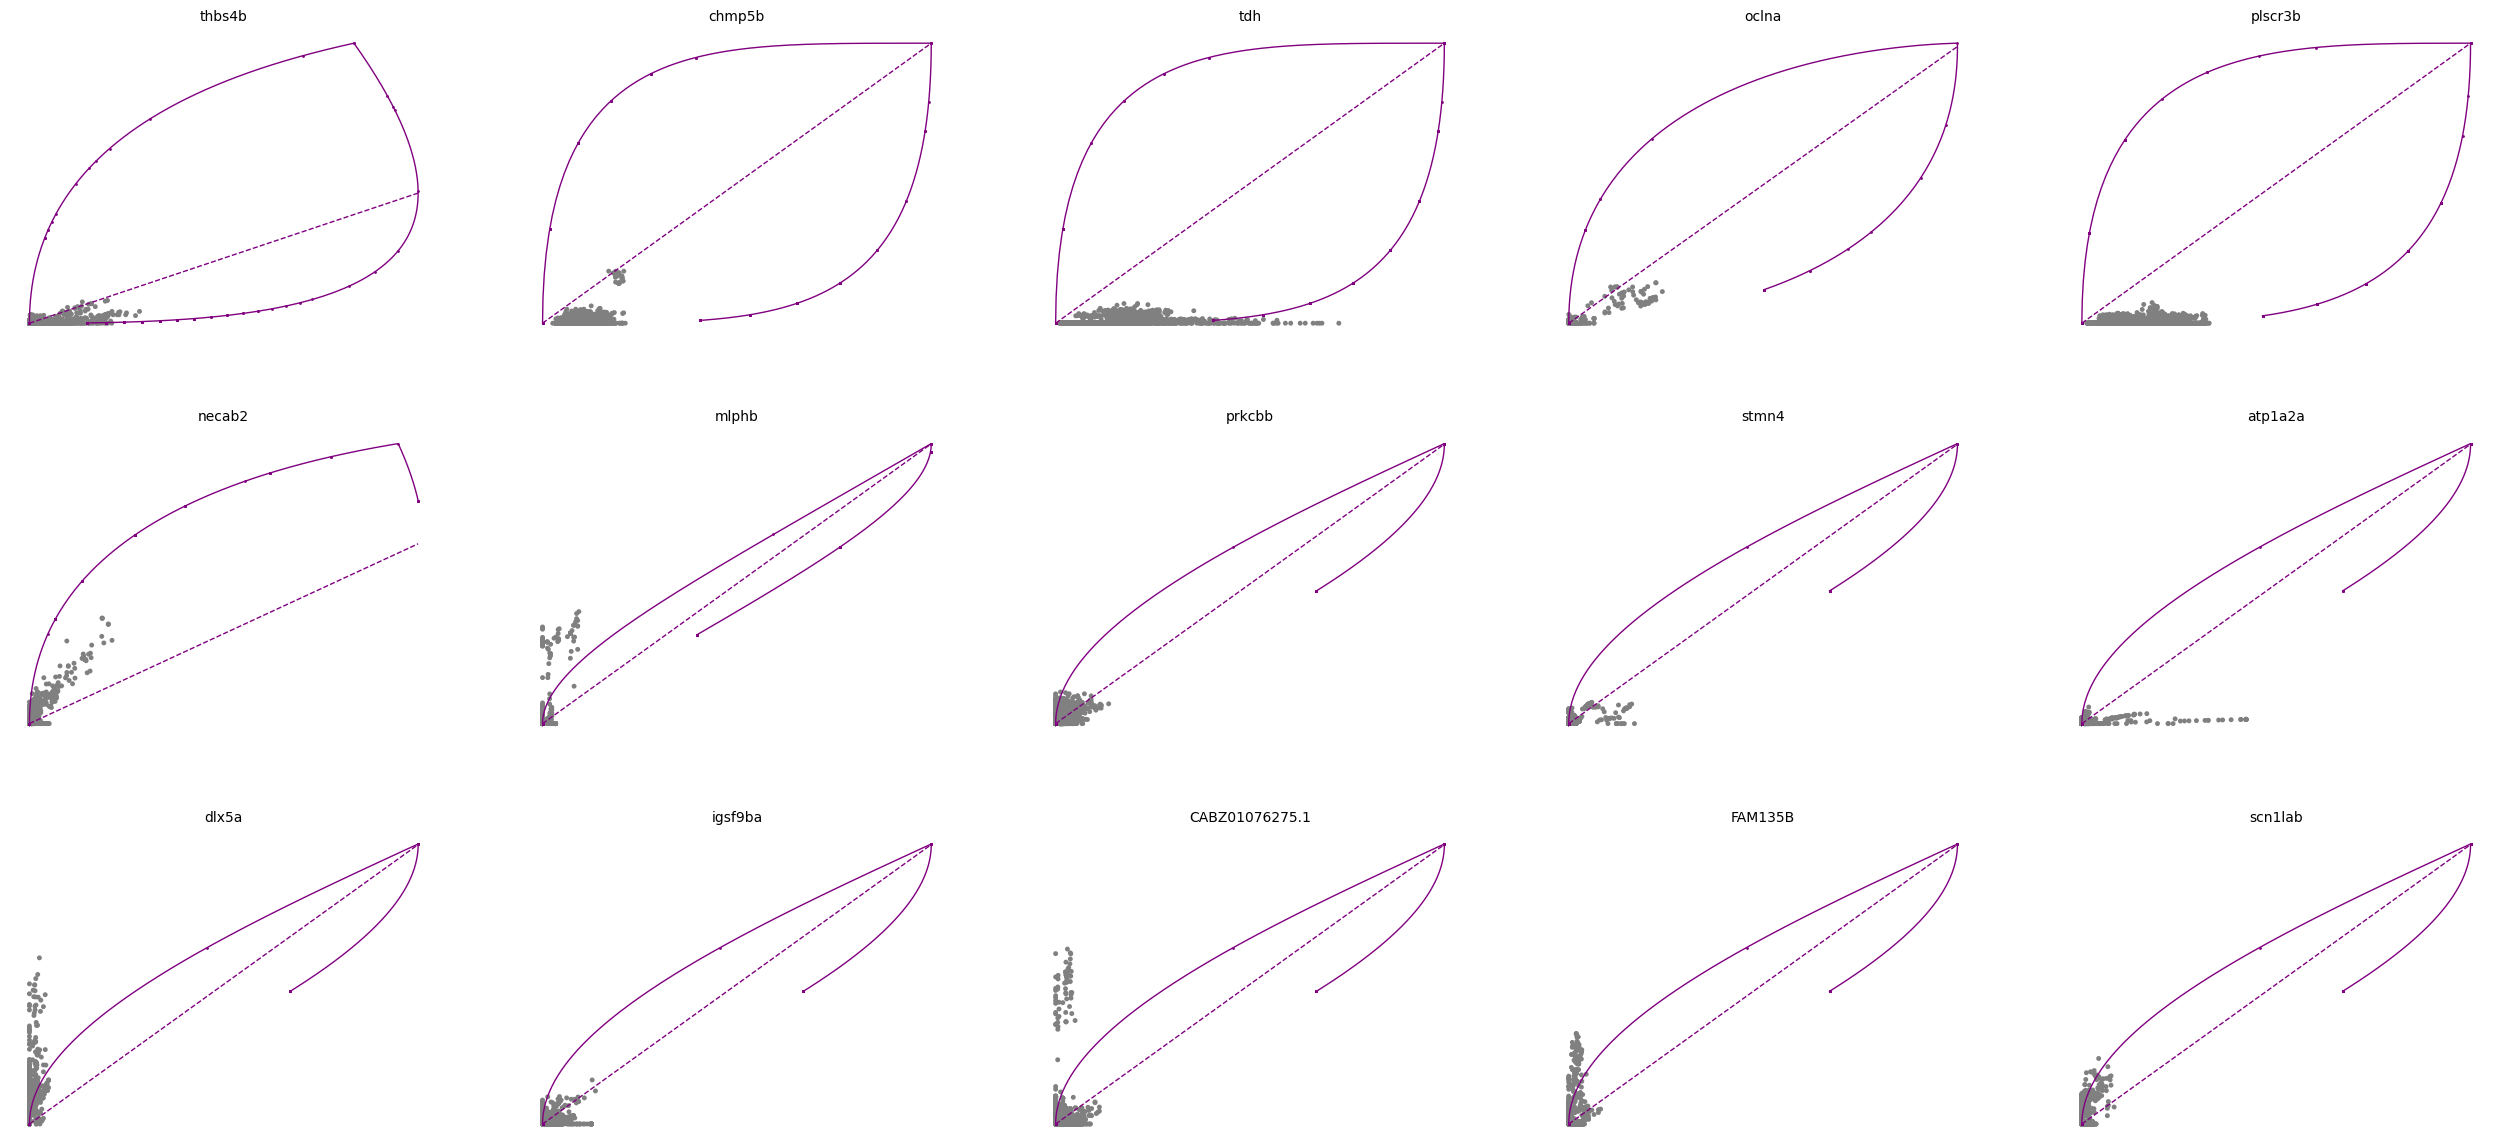

In [ ]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, frameon=False)